# Analyzing Customer Reviews from Amazon

### Analysis of the data and Rating prediction

The purpose of this project is to analyze customer reviews of different headphones listings on Amazon. The reviews will be split into "good" and "bad" sets, and the review texts will be processed into tokens consisting of individual words. These will form the "good" and "bad" review corpuses that will be analyzed to determine the most important words in either good and bad review sets. They will also be used to predict if a review will be "good" or "bad."

This analysis has many real-world applications. While customers can manually include ratings for the product in their reviews, this rating is only an overall statement

In [499]:
### Installation of packages

# tm: Text mining packge
# SnowballC: Stopwords dictionary
# ggplot2: Plotting data
# wordcloud: Making word clouds from the data
# RColorBrewer: Additional color palettes for plots
# e1071: SVM modeling

install.packages('tm')
install.packages('SnowballC')
install.packages('ggplot2')
install.packages('wordcloud')
install.packages('RColorBrewer')
install.packages('e1071')

library(tm)
library(SnowballC)
library(ggplot2)
library(wordcloud)
library(RColorBrewer)
library(e1071)

Warning message:
"package 'tm' is in use and will not be installed"Warning message:
"package 'SnowballC' is in use and will not be installed"


  There is a binary version available but the source version is later:
        binary source needs_compilation
ggplot2  3.3.3  3.3.5             FALSE



installing the source package 'ggplot2'

Warning message:
"package 'wordcloud' is in use and will not be installed"Warning message:
"package 'RColorBrewer' is in use and will not be installed"


  There is a binary version available but the source version is later:
      binary source needs_compilation
e1071  1.7-6  1.7-9              TRUE

  Binaries will be installed


Warning message:
"package 'e1071' is in use and will not be installed"

In [500]:
### Importing the review dataset

df_data = read.csv("AllProductReviews.csv", encoding = 'UTF-8')

n_reviews = nrow(df_data)

cat('Number of columns:', length(df_data), '\n')
cat('Number of rows:', n_reviews)

df_data

Number of columns: 4 
Number of rows: 14337

ReviewTitle,ReviewBody,ReviewStar,Product
Honest review of an edm music lover,No doubt it has a great bass and to a great extent noise cancellation and decent sound clarity and mindblowing battery but the following dissapointed me though i tried a lot to adjust.1.Bluetooth range not more than 10m2. Pain in ear due the conical buds(can be removed)3. Wires are a bit long which makes it odd in front.4. No pouch provided.5. Worst part is very low quality and distoring mic. Other person keeps complaining about my voice.,3,boAt Rockerz 255
Unreliable earphones with high cost,"This earphones are unreliable, i bought it before 15 days meanwhile right side ear buds got cracked automatically and it got divided in two parts, and sound quality is also not that much good but ok, one more thing bass is not good as it is a boat earphones.Guys,Also for the proof i have attached picsPlease see and think before buying<U+200B> this unreliable product.Thanks.",1,boAt Rockerz 255
Really good and durable.,"i bought itfor 999,I purchased it second time, gifted first one to brother. This is really good.Sound quality is really good.You can connect 2 devices at a time.I connect laptop and mobile both.when listening muaic on Lappy, if u get a call, it switches to mobile,this switch between device is not good but again in this price its awesome.Battery stand by is 36 hours for me, and i have used it continously for 8 hours in one go. So Battery life is pretty awesome.Comfortable on ear.",4,boAt Rockerz 255
stopped working in just 14 days,Its sound quality is adorable. overall it was good but just for 2 weeks after that it stopped working and since then it never powered on again. I am claiming for warrenty and it is still undergoing.,1,boAt Rockerz 255
Just Awesome Wireless Headphone under 1000...<U+0001F609>,Its Awesome... Good sound quality & 8-9 hrs battery life... Just waww look... <U+0001F609> I brought just 999 rupees...But Amazon's Packageing system is Very bad... Very poor packaging... Flipcart's packaging system is much better than Amazon...,5,boAt Rockerz 255
Charging port not working,"After 11 days, the charging port isn't working and now I can't even return it. Wat to do ?? I know there is one year warranty but it is only been 11 days. C'mon boat, please send me new one.",1,boAt Rockerz 255
Loved the color and sound !!,Sound-4.5/5Build quality-4.5/5Battery life -4/5Earphones quality is good with strong magnetic lock... Straps is good quality and the earphones wires are too good... Buttons quality is good.. sound is full of punchy bass and and balanced treble and has sorrund effect.. good fitting in ears.. hope connectivity is good.. bcz my last boat Bluetooth bassheads 225 had connection issues... This is worth its price... Hope the packaging was good ...there was no bubble wrapping..,4,boAt Rockerz 255
Great sound with worst mic.,After one month usage reviewing this .Pros-1- sound quality2- design3- weight4- batteryCons1- very bad mic for talking2- can't use while riding bike3 - Music is too loud,3,boAt Rockerz 255
Battery life is good enough to keep going all day,I can’t get enough of this earphone! The bass is amazing and is perfect for a music lover. The battery life is good enough to keep me going all day. The fact that I can connect my laptop and phone at the same time and switch between them makes the experience so much better. I use my earphones a lot for voice calls and this doesn’t let me down at all. This is a must buy for all music lovers.,5,boAt Rockerz 255
Very very bad Durabity,The product durability is 1 month..I just lost my bill details so i cant claim my warrenty .. But this earphones built quality is bad . It stops wrking completely after 1 month sep 14 to nov 11 <U+0001F448> life span .. Dont lose ur bill details incase u want that warranty.. And after purchasing u must register ur product in boat's site for replacement and warranty,1,boAt Rockerz 255


### To facilitate easier processing, I will assign good reviews to '1' and bad reviews to '0'

Number of 1 star reviews: 2493 
Number of 2 star reviews: 939 
Number of 3 star reviews: 1503 
Number of 4 star reviews: 3189 
Number of 5 star reviews: 6213 


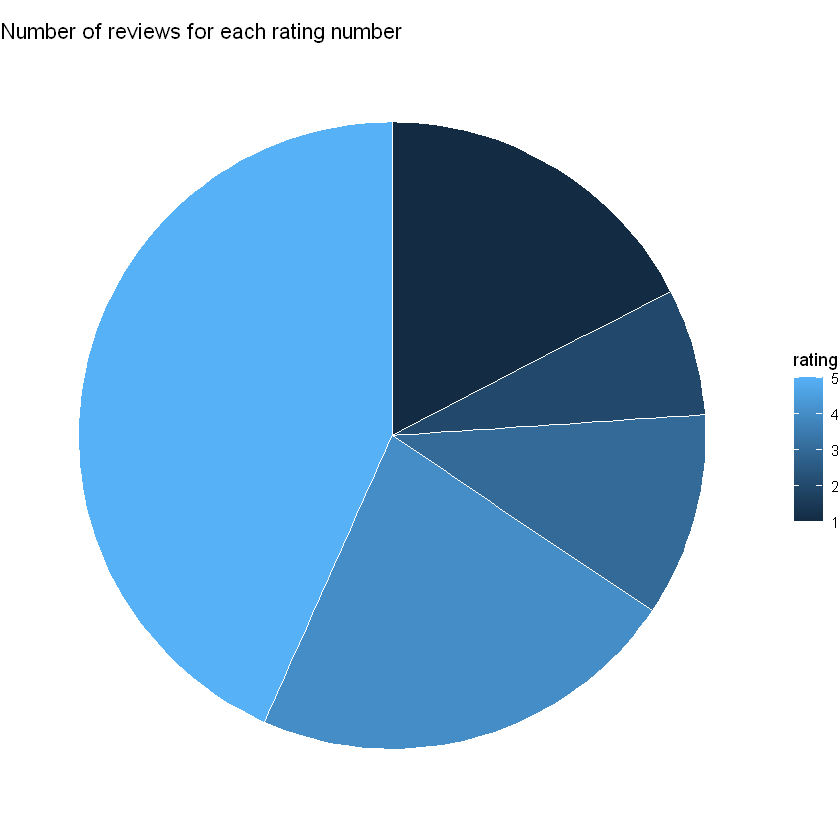

In [501]:
### View the number of reviews from each rating

rating = c(1,2,3,4,5)  # Amazon uses a 5 star rating system
ratingnum = c()

for (i in rating) {
    # Loop through rating values and add number of reviews for that value to ratingnum
    ratingnum = c(ratingnum, length(df_data[df_data$ReviewStar == i, 3]) )
    
    # Print the number
    cat('Number of', i, 'star reviews:', ratingnum[i], '\n')
}

# Convert to a dataframe
ratingdata = data.frame(rating = rating, ratingnum = ratingnum)

# Plot in a bar chart
ggplot(ratingdata, aes(x = '', y = ratingnum, fill = rating, color = rating)) +
  geom_bar(stat = 'identity', color = 'white') +
  coord_polar('y') +
  theme_void() +
  ggtitle('Number of reviews for each rating number')

In [502]:
# Combined: Column that combines the ReviewTitle and ReviewBody contents
df_data$Combined = paste(df_data[[1]], df_data[[2]])

## Binning the reviews into categories and merging title/body text

The number of 5 star reviews is larger than the number of 1, 2, and 3 star reviews combined - the number of 2 star reviews doesn't even break 1000. The data is thus skewed, and if machine learning algorithms are run with the current 5 categories, it would likely be innaccurate.

From a business's perspective, though, customer satisfaction is key - any rating lower than perfect can be considered bad. If the customer left a low rating, they were unsatisfied with something, and discovering these issues is important for guiding product development.

I will create two class bins - "good" reviews consisting of 4/5 star reviews, and "bad" reviews consisting of all others (1-3 star reviews). This is technically still skewed toward the good review category, but this is a fairly accurate representation of sentiment - a 4 star rating or better would typically be considered good on a 5 star spectrum.

I will also merge the title with the body into a single text block - this is because the title acts as a summarized version of the review where the most important criticism is noted.

In [503]:
### For the SVM analysis, it will be easier to work with 0 (bad review) and 1 (good review)

# Make a copy of the original DF to avoid any errors
df_data2 = df_data

# good review = rating >=4
# bad review = rating < 4
cutoff = 4

### Changing labels for the SVM analysis
df_data2$ReviewStar[ df_data2$ReviewStar < cutoff] = 0
df_data2$ReviewStar[ df_data2$ReviewStar >= cutoff] = 1

df_data2

ReviewTitle,ReviewBody,ReviewStar,Product,Combined
Honest review of an edm music lover,No doubt it has a great bass and to a great extent noise cancellation and decent sound clarity and mindblowing battery but the following dissapointed me though i tried a lot to adjust.1.Bluetooth range not more than 10m2. Pain in ear due the conical buds(can be removed)3. Wires are a bit long which makes it odd in front.4. No pouch provided.5. Worst part is very low quality and distoring mic. Other person keeps complaining about my voice.,0,boAt Rockerz 255,Honest review of an edm music lover No doubt it has a great bass and to a great extent noise cancellation and decent sound clarity and mindblowing battery but the following dissapointed me though i tried a lot to adjust.1.Bluetooth range not more than 10m2. Pain in ear due the conical buds(can be removed)3. Wires are a bit long which makes it odd in front.4. No pouch provided.5. Worst part is very low quality and distoring mic. Other person keeps complaining about my voice.
Unreliable earphones with high cost,"This earphones are unreliable, i bought it before 15 days meanwhile right side ear buds got cracked automatically and it got divided in two parts, and sound quality is also not that much good but ok, one more thing bass is not good as it is a boat earphones.Guys,Also for the proof i have attached picsPlease see and think before buying<U+200B> this unreliable product.Thanks.",0,boAt Rockerz 255,"Unreliable earphones with high cost This earphones are unreliable, i bought it before 15 days meanwhile right side ear buds got cracked automatically and it got divided in two parts, and sound quality is also not that much good but ok, one more thing bass is not good as it is a boat earphones.Guys,Also for the proof i have attached picsPlease see and think before buying<U+200B> this unreliable product.Thanks."
Really good and durable.,"i bought itfor 999,I purchased it second time, gifted first one to brother. This is really good.Sound quality is really good.You can connect 2 devices at a time.I connect laptop and mobile both.when listening muaic on Lappy, if u get a call, it switches to mobile,this switch between device is not good but again in this price its awesome.Battery stand by is 36 hours for me, and i have used it continously for 8 hours in one go. So Battery life is pretty awesome.Comfortable on ear.",1,boAt Rockerz 255,"Really good and durable. i bought itfor 999,I purchased it second time, gifted first one to brother. This is really good.Sound quality is really good.You can connect 2 devices at a time.I connect laptop and mobile both.when listening muaic on Lappy, if u get a call, it switches to mobile,this switch between device is not good but again in this price its awesome.Battery stand by is 36 hours for me, and i have used it continously for 8 hours in one go. So Battery life is pretty awesome.Comfortable on ear."
stopped working in just 14 days,Its sound quality is adorable. overall it was good but just for 2 weeks after that it stopped working and since then it never powered on again. I am claiming for warrenty and it is still undergoing.,0,boAt Rockerz 255,stopped working in just 14 days Its sound quality is adorable. overall it was good but just for 2 weeks after that it stopped working and since then it never powered on again. I am claiming for warrenty and it is still undergoing.
Just Awesome Wireless Headphone under 1000...<U+0001F609>,Its Awesome... Good sound quality & 8-9 hrs battery life... Just waww look... <U+0001F609> I brought just 999 rupees...But Amazon's Packageing system is Very bad... Very poor packaging... Flipcart's packaging system is much better than Amazon...,1,boAt Rockerz 255,Just Awesome Wireless Headphone under 1000...<U+0001F609> Its Awesome... Good sound quality & 8-9 hrs battery life... Just waww look... <U+0001F609> I brought just 999 rupees...But Amazon's Packageing system is Very bad... Very poor packaging... Flipcart's packaging system is m

Number of good reviews:  9402 
Number of bad reviews:  4935 


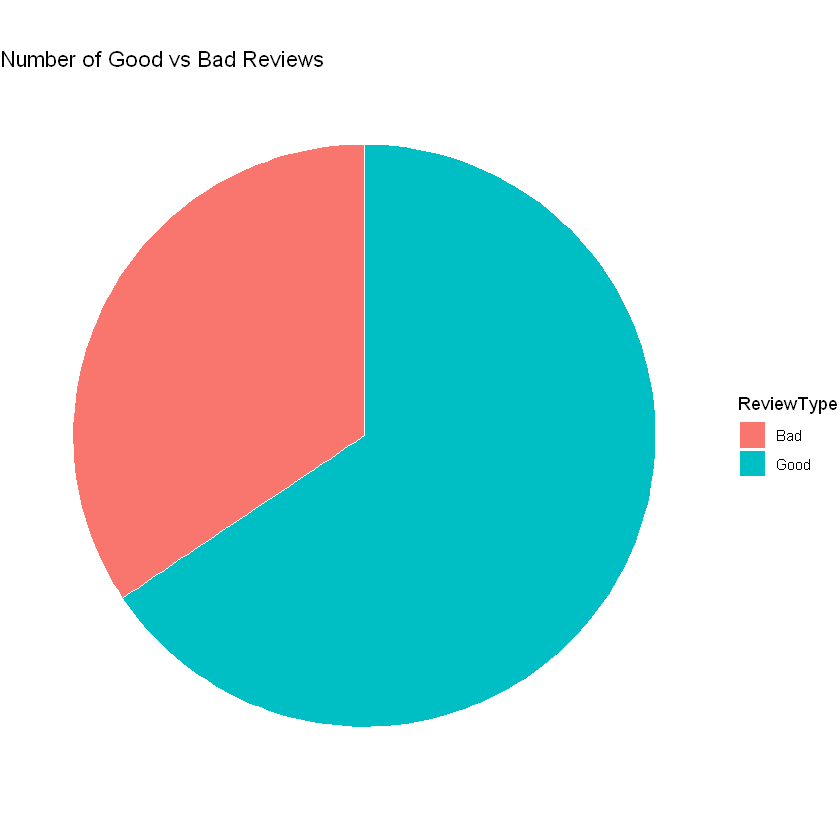

In [504]:
### Split data into good and bad reviews

df_good = df_data2[ df_data2$ReviewStar == 1, 'Combined']
df_bad = df_data2[ df_data2$ReviewStar == 0, 'Combined']

cat('Number of good reviews: ', length(df_good), '\n')
cat('Number of bad reviews: ', length(df_bad), '\n')

pie_data = data.frame(num = c(length(df_good), length(df_bad)), ReviewType = c('Good', 'Bad'))

ggplot(pie_data, aes(x = '', y = num, fill = ReviewType )) +
  geom_bar(stat = 'identity', color = 'white') +
  coord_polar('y') +
  theme_void() +
  ggtitle('Number of Good vs Bad Reviews')

In [505]:
for (i in c(1:5)) {
    print(df_good[i])
}

[1] "Really good and durable.\n i bought itfor 999,I purchased it second time, gifted first one to brother. This is really good.Sound quality is really good.You can connect 2 devices at a time.I connect laptop and mobile both.when listening muaic on Lappy, if u get a call, it switches to mobile,this switch between device is not good but again in this price its awesome.Battery stand by is 36 hours for me, and i have used it continously for 8 hours in one go. So Battery life is pretty awesome.Comfortable on ear.\n"
[1] "Just Awesome Wireless Headphone under 1000...<U+0001F609>\n Its Awesome... Good sound quality & 8-9 hrs battery life... Just waww look... <U+0001F609> I brought just 999 rupees...But Amazon's Packageing system is Very bad... Very poor packaging... Flipcart's packaging system is much better than Amazon...\n"
[1] "Loved the color and sound !!\n Sound-4.5/5Build quality-4.5/5Battery life -4/5Earphones quality is good with strong magnetic lock... Straps is good quality and th

In [506]:
for (i in c(1:5)) {
    print(df_bad[i])
}

[1] "Honest review of an edm music lover\n No doubt it has a great bass and to a great extent noise cancellation and decent sound clarity and mindblowing battery but the following dissapointed me though i tried a lot to adjust.1.Bluetooth range not more than 10m2. Pain in ear due the conical buds(can be removed)3. Wires are a bit long which makes it odd in front.4. No pouch provided.5. Worst part is very low quality and distoring mic. Other person keeps complaining about my voice.\n"
[1] "Unreliable earphones with high cost\n This  earphones are unreliable, i bought it before 15 days meanwhile right side ear buds got cracked automatically and it got divided in two parts, and sound quality is also not that much good but ok, one more thing bass is not good as it is a boat earphones.Guys,Also for the proof i have attached picsPlease see and think before buying<U+200B> this unreliable product.Thanks.\n"
[1] "stopped working in just 14 days\n Its sound quality is adorable. overall it was go

## Useful functions for building the corpus

In [507]:
# Create a function that will perform preprocessing required for building the corpus

build_corpus = function(vec, myStopWords) {
  ### Build a preprocessing function to build a word corpus
  ### Input: A vector containing all documents, a vector containing stopwords
  ### Output: A word corpus with all preprocessing steps completed
  # Tasks:
  # Create the corpus
  # Strip most/all punctuation
  # Split corpus into individual words and save to own variable
  # Convert to all lowercase
  # Delete all stop words - find an existing list and add anything
  # Stem
  ### Check the stems
  # Set min/max limits
  # Delete numbers (can be ratings, price, product number, date; probably not useful)
  
  ### Create the corpus
  vec_corp = VCorpus(VectorSource(vec))
    
  ### Delete the new line markers
  vec_corp = tm_map(vec_corp, content_transformer(gsub), pattern = '\n', replacement = ' ')
  
  ### Remove punctuations
  # Replace ',' '.' '/' with spaces first to avoid accidental word merges (ex: good.You --> goodYou)
  vec_corp = tm_map(vec_corp, content_transformer(gsub), pattern = ',', replacement = ' ')
  vec_corp = tm_map(vec_corp, content_transformer(gsub), pattern = '\\.', replacement = ' ')
  vec_corp = tm_map(vec_corp, content_transformer(gsub), pattern = '\\/', replacement = ' ')
  
  # Remove UTF-8 errors
  #vec_corp = tm_map(vec_corp, content_transformer(gsub), pattern = '\\<U.+?\\>', replacement = ' ')
  
  # Remove general punctuation
  vec_corp = tm_map(vec_corp, removePunctuation)
  
  ### Remove numbers
  vec_corp = tm_map(vec_corp, removeNumbers)
  
  ### Convert to lower case
  vec_corp = tm_map(vec_corp, content_transformer(tolower))
  
  ### Remove stopwords
  vec_corp = tm_map(vec_corp, removeWords, tolower(myStopWords))
  
  ### Perform stemming
  vec_corp = tm_map(vec_corp, stemDocument)
  
  ### Eliminate extra whitespaces
  vec_corp = tm_map(vec_corp, stripWhitespace)
  
  return(vec_corp)
}

In [508]:
# Create a list of stopwords to delete

# Delete product names (derived from the original data)
products = tolower(unique(df_data$Product))

# Add any custom terms that may appear often in reviews
custom = c('u', 'ur', 'headphone', 'headphones', 'earphone', 'earphones')

# Words pertaining to quality
quality = c('good', 'nice', 'best', 'bad', 'worst', 'excellent', 'great', 'superb', 'superior', 'super', 'worth', 'ok', 
           'better', 'fine', 'perfect', 'cheap', 'awful', 'poor', 'not good', 'worse', 'substandard', 'adequate', 
           'inadequate', 'terrible', 'satisfactory', 'unsatistfactory', 'unacceptable', 'inferior', 'awesome', 'like',
           'love', 'hate', '')

# Create the stopwords list
myStopWords = c(stopwords('en'), custom, products)

In [509]:
# Term weighting - TF = Term frequency, TFIDF = TF + inverse document frequency
ctrl_tf = list(weighting = weightTf)#, bounds = list(local = c(0,Inf)))
ctrl_tfidf = list(weighting = weightTfIdf)#, bounds = list(local = c(0,Inf)))

In [510]:
# Sparsity - delete terms that appear too infrequently
sparse_threshold = 0.98 # This means kept-tokens must appear in at least 2% of documents

## Build a corpus containing all reviews
This will help us to visualize various aspects of the data. I mainly will build bar chart and a wordcloud to visualize the most common words in all reviews

In [511]:
# Build corpus containing all reviews
# Remove words relating to quality as well
review_corp_all = build_corpus(df_data$Combined, c(myStopWords, quality))

In [512]:
# Convert the corpus to a document-term matrix (DTM) for further processing
all_dtm = DocumentTermMatrix(review_corp_all, control = ctrl_tfidf)

Warning message in weighting(x):
"empty document(s): 1559 1756 1922 2093 2102 2116 2249 2259 2272 2273 2274 2290 2327 2330 2370 2445 2449 2451 2486 2509 2511 2551 2555 2577 2595 2658 2669 2717 2790 2805 2851 2920 2942 2975 2999 3038 3048 3053 3093 3111 3127 3158 3172 3185 3198 3209 3222 3226 3256 3281 3294 3332 3337 3338 3340 3341 3342 3361 3370 3432 3443 3469 3476 3490 3507 3508 3620 3621 3709 3739 3740 3797 3812 3833 3838 3931 4106 4126 4128 4129 4130 4131 4132 4133 4148 4170 4172 4173 4175 4179 4205 4214 4219 4289 4292 4317 4330 4331 4332 4333 4344 4349 4374 4376 4412 4415 4434 4457 4561 4586 4609 4647 4668 4676 4696 4717 4725 4771 4815 4830 4832 4857 4859 4860 4861 4862 4864 4887 5051 5056 5081 5098 5104 5112 5158 5233 5236 5316 5333 5342 5351 5377 5387 5399 5404 5410 5413 5416 5419 5435 5605 5623 5643 5649 5654 5699 5710 5715 5716 5720 5723 5742 5753 5755 6063 6066 6093 6118 6140 6143 6172 6190 6199 6222 6243 6244 6265 6278 6332 6339 6400 6414 6475 6476 6487 6491 6542 6569 6595 65

In [513]:
# Remove sparse terms
all_dtm2 = removeSparseTerms(all_dtm, sparse_threshold)

In [591]:
# Compare the first review before preprocessing, as stored in the corpus, and as stored in the DTM
cat('Original text from review 1:\n\n')
cat(df_data$Combined[1], '\n\n')

cat('Pre-processed text from review 1 in the corpus:\n\n')
inspect(review_corp_all[[1]])

cat('\n\nPre-processed text from review 1 in the DTM:\n\n')
inspect(all_dtm2[1,])

Original text from review 1:

Honest review of an edm music lover
 No doubt it has a great bass and to a great extent noise cancellation and decent sound clarity and mindblowing battery but the following dissapointed me though i tried a lot to adjust.1.Bluetooth range not more than 10m2. Pain in ear due the conical buds(can be removed)3. Wires are a bit long which makes it odd in front.4. No pouch provided.5. Worst part is very low quality and distoring mic. Other person keeps complaining about my voice.
 

Pre-processed text from review 1 in the corpus:

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 283

honest review edm music lover doubt bass extent nois cancel decent sound clariti mindblow batteri follow dissapoint though tri lot adjust bluetooth rang m pain ear due conic budscan remov wire bit long make odd front pouch provid part low qualiti distor mic person keep complain voic


Pre-processed text from review 1 in the DTM:

<<DocumentTermMatrix (documents: 1, terms: 107)>>

In [515]:
# Convert to temporary data frame for visualization preprocessing
all_dtm_temp = data.frame(as.matrix(all_dtm2)) # DF where each column has the TFIDF of each term for each document

# Sort by TFIDF values
all_dtm_sorted = apply(all_dtm_temp, 2, sum, decreasing = TRUE) # The summation of all TFIDF for each term in order
                      

# Create the data frame
all_dtm_df = data.frame(terms = colnames(all_dtm_temp), count = all_dtm_sorted) # DF version with terms and counts

all_dtm_df

,terms,count
also,also,272.38692
amaz,amaz,361.70801
amazon,amazon,213.88629
audio,audio,121.97624
averag,averag,274.14162
backup,backup,222.10047
bass,bass,693.36320
batteri,batteri,566.19072
bit,bit,137.92368
bluetooth,bluetooth,321.20397


### Visualizing some of the most important terms in all reviews

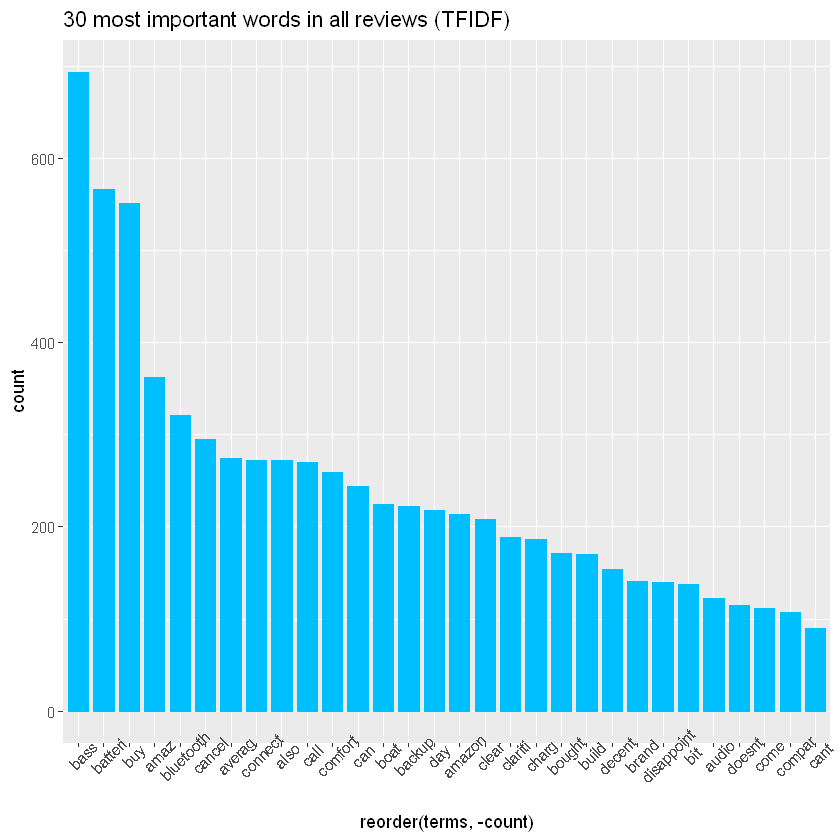

In [516]:
# Plot the 20 most common words
ggplot( data = head(all_dtm_df, 30), aes(reorder(terms, -count), count)) +
    geom_col(color = 'deepskyblue', fill = 'deepskyblue' , width = .8) +
    labs(title = '30 most important words in all reviews (TFIDF)') +
    theme(axis.text.x = element_text(angle = 45))

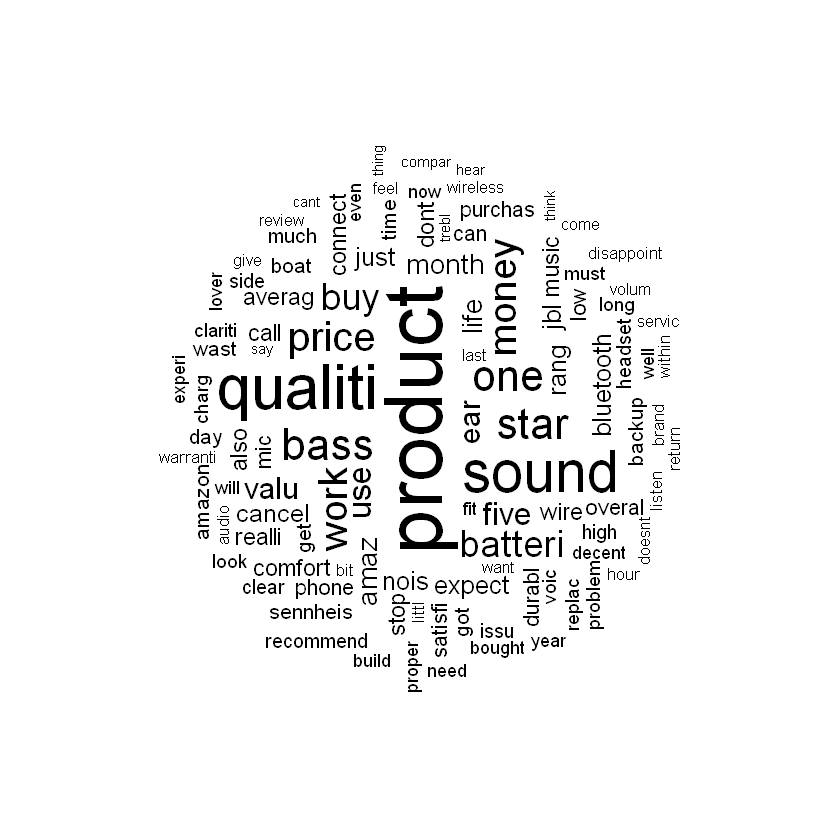

In [517]:
# View the data in a wordcloud
wordcloud(words = all_dtm_df$terms,
         freq = all_dtm_df$count,
         random.order = FALSE,
         rot.per = .35)

### Conclusions for the overall review DTM

Without most words referring to preference/sentiment (removed in the stopwords step), a few words regarding headphone quality appear to be the most discussed across all reviews. Some conclusions can be made, but for a more accurate analysis, the context of these words would need to be considered:

**Most important word:**
* product: Most likely referring to the product being reviewed, but could indicate other products being compared

**Various terms indicate focus on build quality:**
* qualiti/comfort
* batteri/life/charg
* work/problem
* bluetooth/connect

**Various terms indicate focus on sound quality:**
* sound/clariti
* bass/trebl
* audio
* volum

**Various terms indicate focus on product features:**
* bluetooth
* headset
* mic
* wire/wireless/call

**Various terms indicate focus on customer experience:**
* servic/experi
* averag
* recommend/decent/durabl
* cancel/replac/warranti: Most likely these customers are looking to refund or replace their headphones
* amaz: Most likely referring to Amazon, this may refer to the buying/shipping experience

**Various terms indicate focus on price and product value:**
* price/bought/buy
* valu/money
* warranti

## Building a corpus for good and bad reviews

In [518]:
# Build the corpus
# This time, don't remove words pertaining to preference

review_corp_good = build_corpus(df_good, myStopWords)
review_corp_bad = build_corpus(df_bad, myStopWords)

# Build the DTMs
good_dtm = DocumentTermMatrix(review_corp_good, control = ctrl_tfidf)
bad_dtm = DocumentTermMatrix(review_corp_bad, control = ctrl_tfidf)

# Remove sparse terms
good_dtm2 = removeSparseTerms(good_dtm, sparse_threshold)
bad_dtm2 = removeSparseTerms(bad_dtm, sparse_threshold)

# Convert to data frames
good_dtm_temp = data.frame(as.matrix(good_dtm2))
good_dtm_sorted = sort(colSums(good_dtm_temp), decreasing = TRUE)
good_dtm_df = data.frame(terms = names(good_dtm_sorted), count = good_dtm_sorted)

bad_dtm_temp = data.frame(as.matrix(bad_dtm2))
bad_dtm_sorted = sort(colSums(bad_dtm_temp), decreasing = TRUE)
bad_dtm_df = data.frame(terms = names(bad_dtm_sorted), count = bad_dtm_sorted)

Warning message in weighting(x):
"empty document(s): 1951 2313 2683 3028 4453 4505 4524 6731 7851 7930 8442 8503 8655 8691 8726 8861 8976 9144 9194 9195"Warning message in weighting(x):
"empty document(s): 1001 1434 3231 4247 4283 4325 4674"

Number of important words in the good reviews:  114

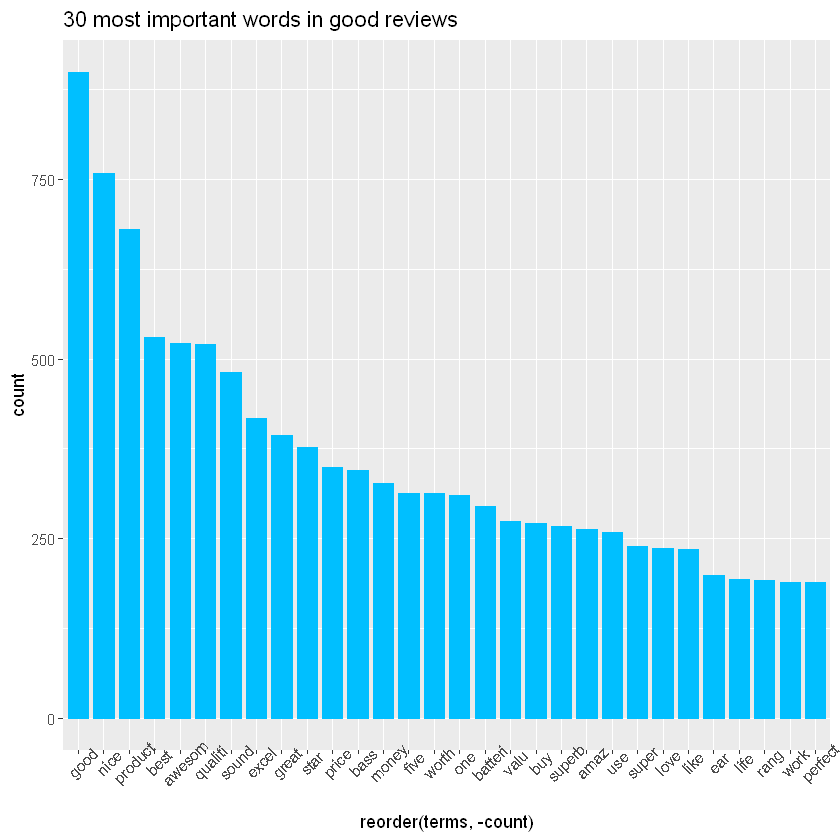

In [519]:
# View the most important words in the good reviews
cat('Number of important words in the good reviews: ', nrow(good_dtm_df))

ggplot( data = head(good_dtm_df, 30), aes(reorder(terms, -count), count)) +
    geom_col(color = 'deepskyblue', fill = 'deepskyblue' , width = .8) +
    labs(title = '30 most important words in good reviews') +
    theme(axis.text.x = element_text(angle = 45))

Number of important words in the bad reviews:  138

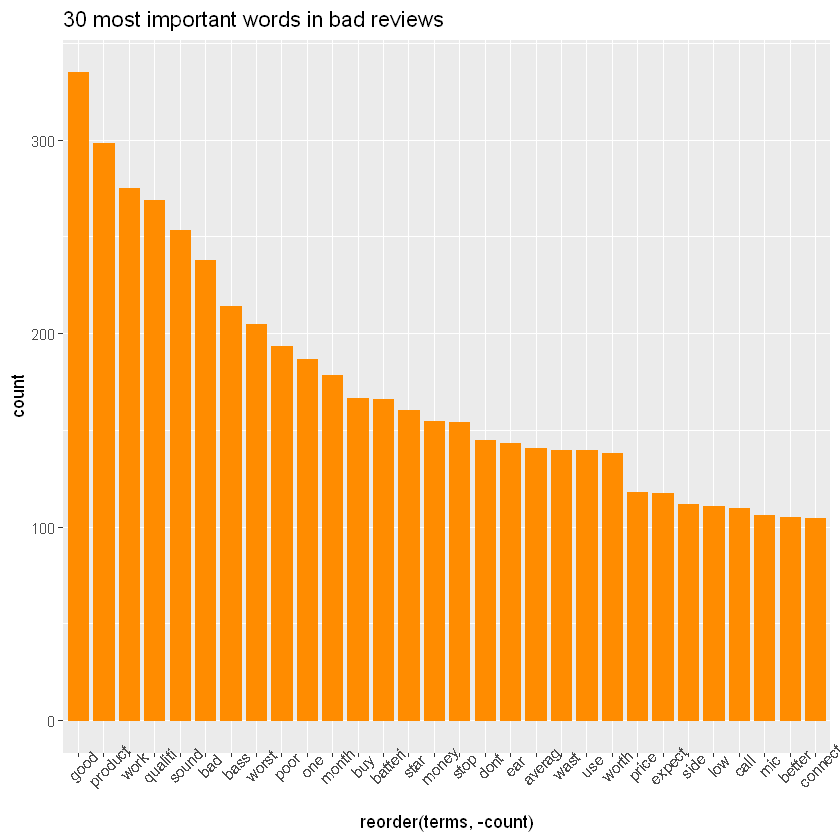

In [520]:
# View the most important words in the good reviews
cat('Number of important words in the bad reviews: ', nrow(bad_dtm_df))

ggplot( data = head(bad_dtm_df, 30), aes(reorder(terms, -count), count)) +
    geom_col(color = 'darkorange', fill = 'darkorange' , width = .8) +
    labs(title = '30 most important words in bad reviews') +
    theme(axis.text.x = element_text(angle = 45))

###  Conclusions from the initial analysis of good/bad reviews

The most notable finding is that "good" is ranked as the most important term in both good and bad reviews. This is unexpected, considering that customers who leave bad reviews wouldn't normally conclude that the item was "good." There are two likely reasons for this discrepancy
* The bad reviews include 3-star reviews which fall in the middle of the spectrum - some aspects of the product may be good, but overall, the customer was disappointed
* These reviews may be about how a product is actually "not good" instead of "good"

Another interesting conclusion is how there are more important words in the bad review set than there are in the good review set (138 vs 114). Considering how the bad review set included only 34.4% of the total reviews, I would have expected fewer words in the bad review DTM.

One possible explanation is that people tend to be more comprehensive when leaving bad reviews
* Many good reviews focus on customer sentiment

>'Just go for it\n **Awesome best budget** wireless earphones\n'

>'**SUPERB**\n **Sound quality is good**. noise cancellation is not upto the mark. **battery quality is decent**. by charging it once you can enjoy upto 5hrs of music without any issue\n'
* Bad reviews are often more detailed to emphasize discontent

>'Honest review of an edm music lover\n No doubt it has a great bass and to a great extent noise cancellation and decent sound clarity and mindblowing battery but the following **dissapointed** me though i tried a lot to adjust.1.**Bluetooth range not more than 10m2. Pain in ear due the conical buds(can be removed)3. Wires are a bit long which makes it odd in front.4. No pouch provided.5. Worst part is very low quality and distoring mic**. Other person keeps complaining about my voice.\n'

>'Review update - **Product failed after a few months**\n Update: Sadly this is the **second Boat product to conk off after few months of use**. I guess this is the end of the journey for you and I Boat Audio, **not buying any more products from your brand**. Changed the rating to reflect the same.I was in the market for a cheap pair of Bluetooth earphones and I chanced upon this on a lightning deal and bought it. I have used Boat products before, they have good build quality and their sound is alright. I’m writing this after a month or so, enough time to have lived with it and get to know quirks and other problems.• **The sound is nothing great**, it’s a bit on the bassy side. If you’re a bass lover, this is definitely a good buy.• Connectivity is quick and painless – and it works without hassle every time. **The quality of the connectivity depends and is sometimes weird**. I can put the phone on charge and use it for a distance of about 3 meters, no worries. But sometimes when I’m walking really fast or jogging there are breaks and crackles in audio. Not sure if it’s the material of my gym wear, but it works well when the phone’s in my jeans.• **Battery life is nothing to write home about** – I listen to music constantly even when I’m at work. My demands are probably too high for this price range.• It is sweat-proof as advertised. No interruptions under a light drizzle.• It’s got great build quality for the price – looks and feels premium. Doesn’t tangle at all.• It stays in your ear regardless of the intensity of the exercise which is great.On the whole a great buy if you are looking for a cheaper alternative. Wait for a sale before you get it though.Like my reviews? Please do click the helpful button. It encourages me to share more about the products I use. Thanks!\n'
        

### Adjusting the weights according to importance in good/bad reviews

To address the first issue where "good" seemed prominent in bad reviews, I will adjust the term weighting for shared terms. I will perform this adjustment on the final weight values for easier implementation as otherwise I would most likely need to formulate an entirely different weighting scheme and implement it on the DTM step.

I will extract a list of all shared terms and multiply the good/bad weights by the proportion of the total weight in the good/bad DTM. For example, 'good' has 899.2391 weight in the good DTM and 334.82858 in the bad DTM. 

|Term  |Good    |Bad      |Total     |
|:----:|----:   |----:    |----:     |
|Nice  |899.2391|334.82858|1234.06768|

The equation used to calculate the updated weights is:

$$Weight_{new} = Weight * \frac{Weight}{Total}$$

So the updated weights are:


|Weight  |Good     |Bad      |
|:------:|--------:|--------:|
|Old     |899.2391 |334.82858|
|New     |655.25658|90.84605 |

In [521]:
# List of terms found in both good/bad DTMs
in_both = intersect(good_dtm_df$terms, bad_dtm_df$terms)
in_both_df = data.frame()

# Put the TFIDF weights from both good and bad DTMs into one data frame
for (term in in_both) {
    good = good_dtm_df[good_dtm_df$terms == term, 'count']
    bad = bad_dtm_df[bad_dtm_df$terms == term, 'count']
    
    rowtemp = data.frame(term = term, good = good, bad = bad)
    
    in_both_df = rbind(in_both_df, rowtemp)
}

cat('Number of words in good: ', length(good_dtm_df$terms), 
  '\nNumber of words in bad: ', length(bad_dtm_df$terms),
  '\n\nNumber of words in both sets: ', nrow(in_both_df),
  '\n\n')
cat('Number of words only in good: ', length(setdiff(good_dtm_df$terms, bad_dtm_df$terms)),
    '\nNumber of words only in bad: ', length(setdiff(bad_dtm_df$terms, good_dtm_df$terms)))

in_both_df

Number of words in good:  114 
Number of words in bad:  138 

Number of words in both sets:  86 

Number of words only in good:  28 
Number of words only in bad:  52

term,good,bad
good,899.2391,334.82858
nice,758.3671,87.25750
product,680.0089,298.36457
best,529.7511,42.02128
qualiti,520.1311,268.87535
sound,481.9804,253.12802
great,393.0141,76.71272
star,377.0620,160.48848
price,348.7994,118.05554
bass,345.2199,214.20006


In [522]:
# Adjust the value in the original good/bad DFs according to the percentage of the sum
### ex: if g=200, b=100, then g_new = 200 * (200/(200+100))

# Assign the DF columns for easier code
#term = factor(in_both_df[,1], levels = levels(good_dtm_df$terms))
term = as.character(in_both_df[,1])
gval = in_both_df[,2]
bval = in_both_df[,3]

# Calculate the new good/bad values
g_temp = gval * (gval / (gval + bval))
b_temp = bval * (bval / (gval + bval))

# Replace the values in the original data frame
for (i in c(1:length(term))) {
    i_term = term[i]
    good_dtm_df[ good_dtm_df$terms == i_term, 'count'] = g_temp[i]
    bad_dtm_df[ bad_dtm_df$terms == i_term, 'count'] = b_temp[i]
}

# Mark the words shared between good/bad DTMs
### inboth is a boolean indicator while inboth_count is a scaler for the word cloud
good_dtm_df$inboth = 'N'
good_dtm_df$inboth_count = 7
bad_dtm_df$inboth = 'N'
bad_dtm_df$inboth_count = 7

good_dtm_df[good_dtm_df$terms %in% term, 'inboth'] = 'Y'
bad_dtm_df[bad_dtm_df$terms %in% term, 'inboth'] = 'Y'
good_dtm_df[good_dtm_df$terms %in% term, 'inboth_count'] = 1
bad_dtm_df[bad_dtm_df$terms %in% term, 'inboth_count'] = 1

# Scale the inboth_count columns to the original counts (shrinks the influence of words present in both)
# Add 1 to all values to avoid extremely low values if both values are low (<1)
good_dtm_df$inboth_count = good_dtm_df$inboth_count * good_dtm_df$count + 1
bad_dtm_df$inboth_count = bad_dtm_df$inboth_count * bad_dtm_df$count + 1

In [523]:
good_dtm_df

,terms,count,inboth,inboth_count
good,good,655.25658,Y,656.25658
nice,nice,680.11344,Y,681.11344
product,product,472.63351,Y,473.63351
best,best,490.81812,Y,491.81812
awesom,awesom,522.19104,N,3656.33730
qualiti,qualiti,342.88227,Y,343.88227
sound,sound,316.01472,Y,317.01472
excel,excel,416.91635,N,2919.41446
great,great,328.82956,Y,329.82956
star,star,264.48821,Y,265.48821


In [524]:
bad_dtm_df

,terms,count,inboth,inboth_count
good,good,90.84605,Y,91.84605
product,product,90.98920,Y,91.98920
work,work,162.79669,Y,163.79669
qualiti,qualiti,91.62658,Y,92.62658
sound,sound,87.16238,Y,88.16238
bad,bad,237.71847,N,1665.02927
bass,bass,82.01650,Y,83.01650
worst,worst,204.85440,N,1434.98082
poor,poor,193.24516,N,1353.71615
one,one,70.23340,Y,71.23340


## Visualizing the updated DTMs

Number of important words in the good reviews:  114

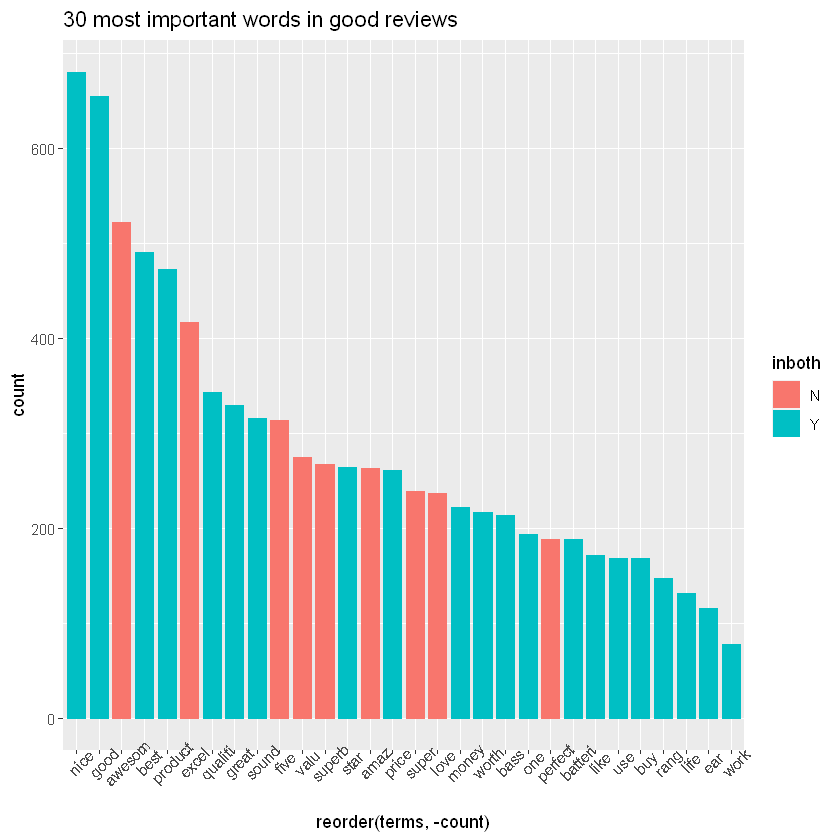

In [525]:
# View the most important words in the good reviews
cat('Number of important words in the good reviews: ', nrow(good_dtm_df))

ggplot( data = head(good_dtm_df, 30), aes(reorder(terms, -count), count, fill = inboth, color = inboth)) +
    geom_col(width = .8) +
    labs(title = '30 most important words in good reviews') +
    theme(axis.text.x = element_text(angle = 45))

Number of important words in the bad reviews:  138

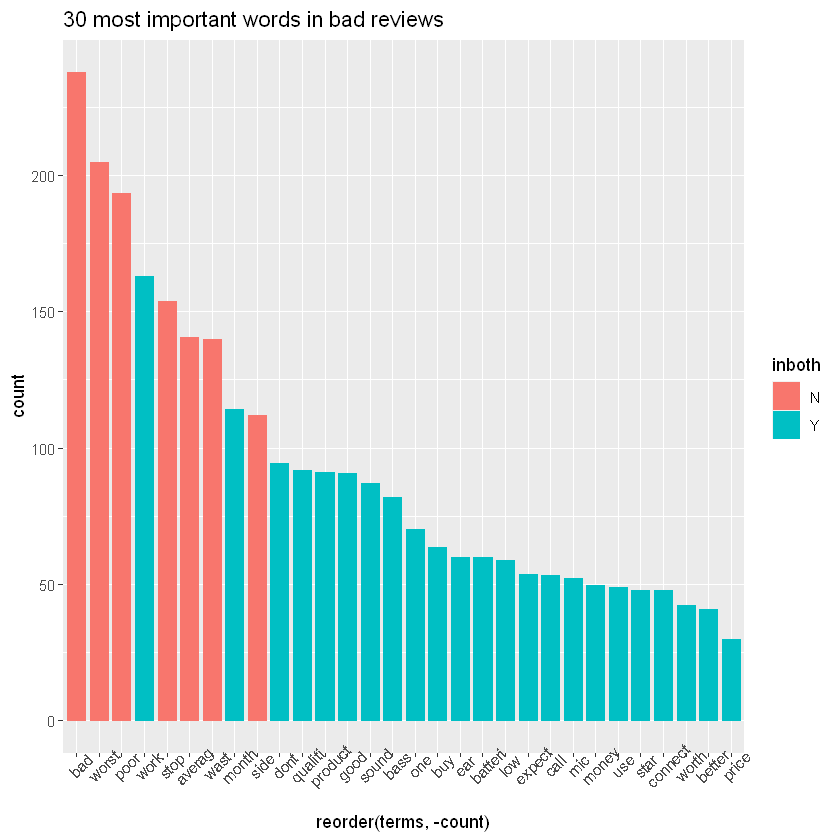

In [526]:
# View the most important words in the good reviews
cat('Number of important words in the bad reviews: ', nrow(bad_dtm_df))

ggplot( data = head(bad_dtm_df, 30), aes(reorder(terms, -count), count, fill = inboth, color = inboth)) +
    geom_col(width = .8) +
    labs(title = '30 most important words in bad reviews') +
    theme(axis.text.x = element_text(angle = 45))

## Word clouds

Red words are unique to the DTM, while blue words are shared between the good and bad review DTMs

Word Cloud: Good reviews
Words unique to good reviews are highlighted in red

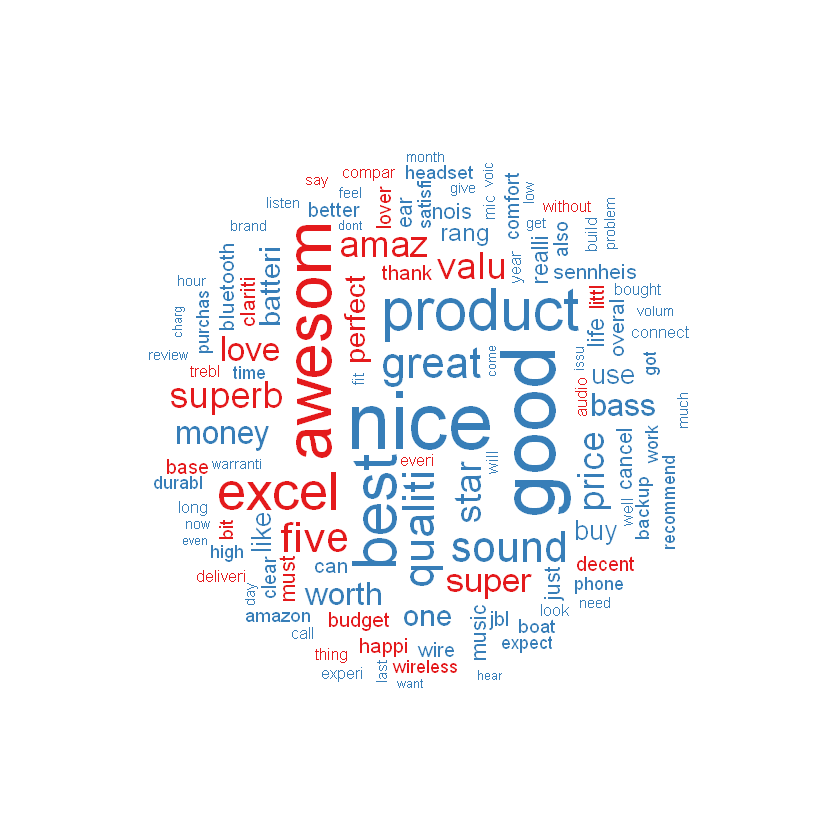

In [527]:
# View the data in a wordcloud
cat('Word Cloud: Good reviews\n')
cat('Words unique to good reviews are highlighted in red')

wordcloud(words = good_dtm_df$terms, 
          freq = good_dtm_df$count, 
          random.order = FALSE,
          rot.per = .35,
          ordered.colors = TRUE,
          colors = brewer.pal(8, 'Set1')[factor(good_dtm_df$inboth)])

Word Cloud: Good reviews
Words unique to good reviews are highlighted in red

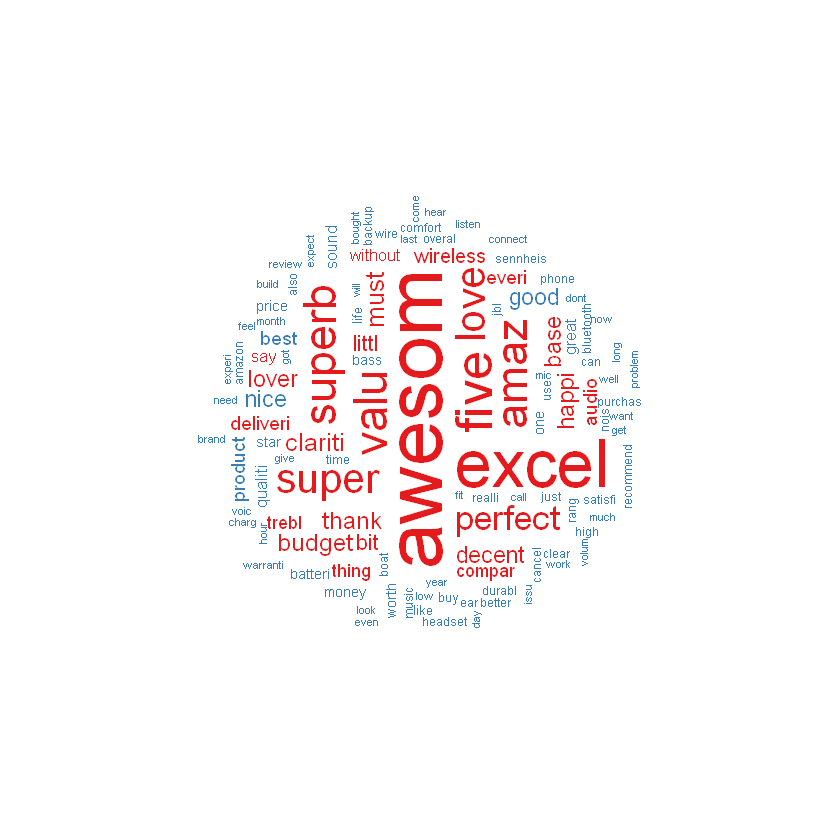

In [528]:
# Same word cloud, but emphasize the words unique to good reviews
cat('Word Cloud: Good reviews\n')
cat('Words unique to good reviews are highlighted in red')

wordcloud(words = good_dtm_df$terms, 
          freq = good_dtm_df$inboth_count, 
          random.order = FALSE,
          rot.per = .35,
          ordered.colors = TRUE,
          colors = brewer.pal(8, 'Set1')[factor(good_dtm_df$inboth)])

Word Cloud: Bad reviews
Words unique to bad reviews are highlighted in red

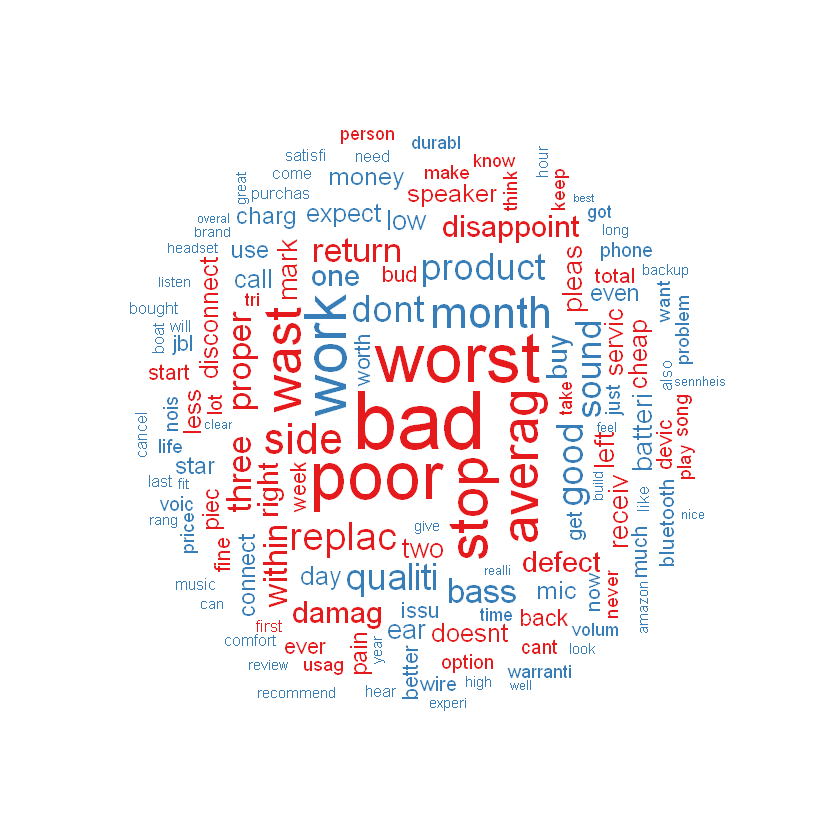

In [529]:
# View the data in a wordcloud
cat('Word Cloud: Bad reviews\n')
cat('Words unique to bad reviews are highlighted in red')

wordcloud(words = bad_dtm_df$terms, 
          freq = bad_dtm_df$count, 
          random.order = FALSE,
          rot.per = .35,
          ordered.colors = TRUE,
          colors = brewer.pal(8, 'Set1')[factor(bad_dtm_df$inboth)])

Word Cloud: Bad reviews
Words unique to bad reviews are highlighted in red

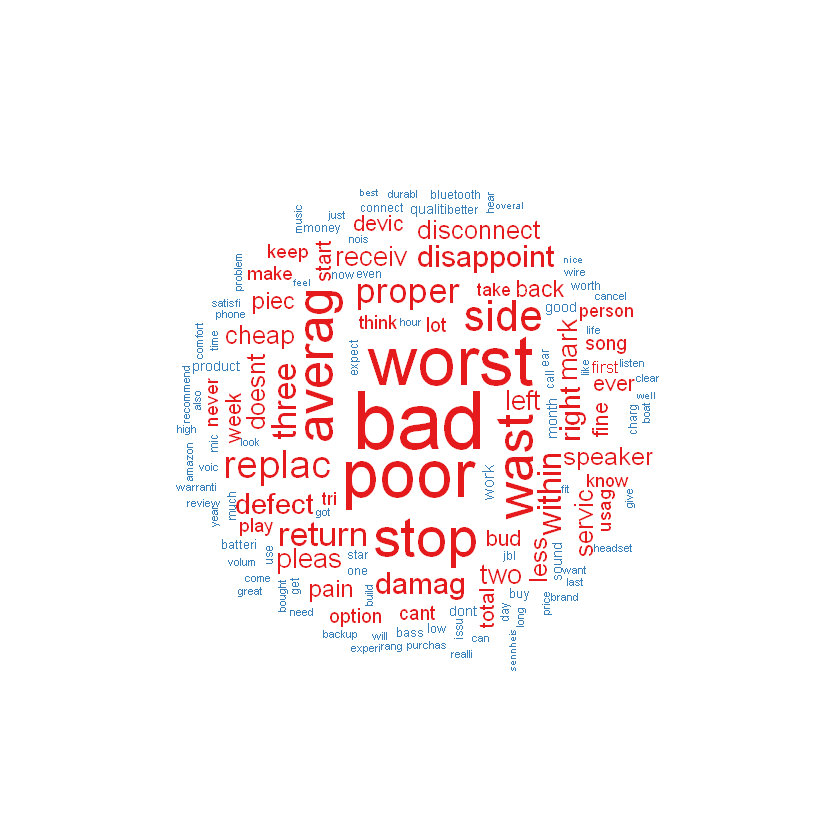

In [530]:
# Same word cloud, but emphasize the words unique to good reviews
cat('Word Cloud: Bad reviews\n')
cat('Words unique to bad reviews are highlighted in red')

wordcloud(words = bad_dtm_df$terms, 
          freq = bad_dtm_df$inboth_count, 
          random.order = FALSE,
          rot.per = .35,
          ordered.colors = TRUE,
          colors = brewer.pal(8, 'Set1')[factor(bad_dtm_df$inboth)])

## Analysis of results

By adding a weight to punish words shared between sets based on the relative proportion of total importance between sets, the resulting list of important words is much more indicative of review content.

The good reviews have a lot shared words at the top of the list ('good', 'best', 'product') while the bad reviews have more unique words at the top ('bad', 'worst', 'work').

The good reviews mainly had words indicating customer sentiment, though there were a few words noting physical features ('sound', 'batteri', 'bass'). The bad reviews similarly had customer sentiment terms, but they included more words noting physical features. These include the aforementioned words from the good reviews, but also include words like 'mic', 'connect', 'call'. 

An interesting unique term from the top of the bad review DTM is 'month.' This is likely referring to the one month return policy on Amazon, or that the product may have stopped working after a month.



# Predicting Review Type

To see if these extracted words can accurately predict whether a review is good or bad, I will build a model using the dataset. I will build an SVM model which is typically effective for text mining applications (especially when the feature count is very high).

To simplify the work, I will not perform the weighting adjustment for words shared between good and bad reviews - for the SVM, this will require customizing a weighting scheme.

## SVM preprocessing

In [544]:
## Split data into training and test sets
sample_size = floor(0.7 * nrow(df_data))
set.seed(100)

df_train = df_data2[sample(nrow(df_data), sample_size),]
df_test = df_data2[-sample(nrow(df_data), sample_size),]

cat('Size of training data set: ', nrow(df_train), '\n')
cat('Size of training data set: ', nrow(df_test), '\n')

df_train

Size of training data set:  10035 
Size of training data set:  4302 


,ReviewTitle,ReviewBody,ReviewStar,Product,Combined
3786,Super bass level,"Super bass level with shape adaptable with ear, perfect fitting earpiece",1,boAt Rockerz 255,"Super bass level Super bass level with shape adaptable with ear, perfect fitting earpiece"
503,Excellent Product,"Absolute Rock Star! No problem in paring with any phones, tried with iphone,samsung and pixel2. Work flawlessly. Great sound and bass effect. Great noise cancellation. Overall a 5 star product.",1,boAt Rockerz 255,"Excellent Product Absolute Rock Star! No problem in paring with any phones, tried with iphone,samsung and pixel2. Work flawlessly. Great sound and bass effect. Great noise cancellation. Overall a 5 star product."
3430,Mic not proper but excellent sound quality,Audio is excellent... As expected from boat.... But mic is not clear... People complaint about my voice not being clear,1,boAt Rockerz 255,Mic not proper but excellent sound quality Audio is excellent... As expected from boat.... But mic is not clear... People complaint about my voice not being clear
3696,Its working as expected.,"Sound Quality is good, price is little bit high. It should be around INR 600/-",1,boAt Rockerz 255,"Its working as expected. Sound Quality is good, price is little bit high. It should be around INR 600/-"
14323,Bad bass quality,No bass,0,JBL T110BT,Bad bass quality No bass
4090,Nothing I noticed,Not good for running,1,boAt Rockerz 255,Nothing I noticed Not good for running
7886,Good Quality! Value for money!,"Light weight, comfortably slips into ear cavities, But System is not compatible with mi mobile phones, operates better with Samsung devices.",1,Sennheiser CX 6.0BT,"Good Quality! Value for money! Light weight, comfortably slips into ear cavities, But System is not compatible with mi mobile phones, operates better with Samsung devices."
3052,I have some issue with this product,Nice head set nd sound quality also good but i did not receive bill or warranty card in this box......plzz reply me for this issue,1,boAt Rockerz 255,I have some issue with this product Nice head set nd sound quality also good but i did not receive bill or warranty card in this box......plzz reply me for this issue
11159,Worth it,"Excellent sound quality, comfortable. But wire is fragile",1,Sennheiser CX 6.0BT,"Worth it Excellent sound quality, comfortable. But wire is fragile"
8192,Best a man can get,Very good product. And finally Sennheiser is Sennheiser. Best in class always,1,Sennheiser CX 6.0BT,Best a man can get Very good product. And finally Sennheiser is Sennheiser. Best in class always


In [545]:
# Build corpuses
train_corp = build_corpus(df_train$Combined, myStopWords)
test_corp = build_corpus(df_test$Combined, myStopWords)

In [546]:
# Build DTMs
train_dtm = DocumentTermMatrix(train_corp, control = list(weighting = weightTfIdf))
train_dtm2 = removeSparseTerms(train_dtm, sparse_threshold)
train_dtm_df = data.frame(as.matrix(train_dtm2))

test_dtm = DocumentTermMatrix(test_corp, control = list(weighting = weightTfIdf))
test_dtm_df = data.frame(as.matrix(test_dtm))

Warning message in weighting(x):
"empty document(s): 53 570 760 1085 2289 2536 2760 3088 3515 4573 4643 5675 6371 6598 9452 9689"Warning message in weighting(x):
"empty document(s): 778 1139 1440 2139 3677 3883 4054 4150"

In [548]:
# Compile the data frame to pass into the SVM
train_dat = data.frame(train_dtm_df, ReviewStar = as.factor(df_train$ReviewStar))
test_dat = data.frame(test_dtm_df, ReviewStar = as.factor(df_test$ReviewStar))

cat('Number of features for training data set: ', ncol(train_dtm_df), '\n')
cat('Number of features for test data set: ', ncol(test_dtm_df), '\n')

train_dat

Number of features for training data set:  132 
Number of features for test data set:  4432 


also,amaz,amazon,audio,averag,awesom,backup,bad,bass,batteri,...,well,will,wire,wireless,within,work,worst,worth,year,ReviewStar
0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.0000000,0.000000,0.4005415,0.0000000,...,0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0,0.0000000,0,1
0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.0000000,0.000000,0.1001354,0.0000000,...,0,0.0000000,0.0000000,0.0000000,0.0000000,0.1210307,0,0.0000000,0,1
0.0000000,0.0000000,0,0.3705362,0,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,...,0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0,0.0000000,0,1
0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,...,0,0.0000000,0.0000000,0.0000000,0.0000000,0.2640669,0,0.0000000,0,1
0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.0000000,1.064145,1.2016245,0.0000000,...,0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0,0.0000000,0,0
0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,...,0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0,0.0000000,0,1
0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,...,0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0,0.0000000,0,1
0.2171166,0.0000000,0,0.0000000,0,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,...,0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0,0.0000000,0,1
0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,...,0,0.0000000,0.5714902,0.0000000,0.0000000,0.0000000,0,0.5114609,0,1
0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,...,0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0,0.0000000,0,1


## Running the SVM

In [550]:
# Finding parameters
#test_svm = tune.svm(ReviewStar~., data = test_dat, kernel = 'radial', cost = .1:10, gamma = .01:1)

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'X.U.0001F44C.lanc' and 'X.U.0001F44D.cel' and 'X.U.0001F601.oreast' and 'X.U.0001F601.sool' and 'aboutth' and 'acc' and 'achedinnnn' and 'alll' and 'amazingconsth' and 'announc' and 'anti' and 'appeal' and 'asset' and 'availableawesom' and 'avial' and 'awesome' and 'awesome.U.2764..U.FE0F.' and 'backupconbuild' and 'baddur' and 'ban' and 'basi' and 'bassthi' and 'been' and 'beforehand' and 'bhaiya' and 'birthday' and 'bleed' and 'boata' and 'boombast' and 'bottomlin' and 'brake' and 'buy.U.0001F44C.n' and 'bwst' and 'callpoor' and 'camcel' and 'cansil' and 'chargabl' and 'chop' and 'clariri' and 'comat' and 'comfortabledur' and 'comput' and 'connet' and 'consprosnois' and 'continuesli' and 'could' and 'cousin' and 'cum' and 'curfew' and 'dam' and 'darood' and 'dedic' and 'devicecan' and 'deviceson' and 'diamet' and 'didnnt' and 'disatisfi' and 'disppoint' and 'distinct' and 'distrot' and 'dop

"Variable(s) 'X.U.0001F3A7.esom' and 'X.U.0001F449.connectivitythndrb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F449.lookt' and 'X.U.0001F4AF.worthnd' and 'X.U.0001F603.ce' and 'X.U.0001F60A.od' and 'X.U.0001F60D.bassi' and 'X.U.0001F60D.oduct' and 'X.U.0001F60D.te' and 'X.U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F31B..U.0001F31B..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917.oduct' and 'X.U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F.' and 'abnorm' and 'abroad' and 'abrupt' and 'accur' and 'addon' and 'ajit' and 'align' and 'allthank' and 'amazingnois' and 'amazong' and 'ambienc' and 'amzon' and 'anoye' and 'are' and 'areplac' and 'asom' and 'atelast' and 'averageso' and 'averga' and 'awayman' and 'awesumm' and 'awrsom' and 'backupwith' and 'bacup' and 'bagcon' and 'basket' and 'bassey' and 'bassgreat' and 'bassi' and 'befikar' and 'besti' and 'bestvfm' and 'blour' and 'b

"Variable(s) 'X.U.0001F442.ngcomfort' and 'X.U.0001F44C.superbb' and 'X.U.0001F44D.comfort' and 'X.U.0001F44D.pduct' and 'X.U.0001F60A.n.sn' and 'X.U.0001F64C..U.0001F64C.heis' and 'X.U.0001F64F..ed..U.00A0..U.00BC.duct' and 'X.U.0001F923..ed..U.00A0..U.00BE.ld' and 'X.U.0001F929..U.0001F929..ed..U.00A0..U.00BE.n' and 'accha' and 'act' and 'afterbon' and 'aliv' and 'alli' and 'andheri' and 'anybodi' and 'aosm' and 'argument' and 'atom' and 'auasom' and 'audiobook' and 'averageconsaft' and 'averageth' and 'awasom' and 'awestruck' and 'awesum' and 'baat' and 'backupnoic' and 'backward' and 'bassextra' and 'becous' and 'besr' and 'bias' and 'brace' and 'bulli' and 'burden' and 'butsometh' and 'buyr' and 'centre.' and 'chest' and 'clamp' and 'clock' and 'cmon' and 'coat' and 'comfortabl' and 'connectivi' and 'consent' and 'consnon' and 'consslight' and 'consth' and 'cont' and 'cooler' and 'couldv' and 'craft' and 'cri' and 'cxunder' and 'debat' and 'demiag' and 'dheer' and 'digit' and 'dis

"Variable(s) 'X.U.0001F449.rphon' and 'X.U.0001F44C.fe' and 'X.U.0001F44D.ke' and 'X.U.0001F60A.esom' and 'X.U.0001F618.ss' and 'X.U.0001F929..ed..U.00A0..U.00BD.r' and 'abount' and 'adequatei' and 'adject' and 'aftar' and 'airpod' and 'amez' and 'approach' and 'approxim' and 'arround' and 'ase' and 'asf' and 'avaj' and 'awesome.U.0001F44C.' and 'awessomegood' and 'bacaus' and 'backupgood' and 'bassamaz' and 'bassit' and 'bassvalu' and 'baterysound' and 'battrey' and 'beautifi' and 'beck' and 'bedcant' and 'beginleft' and 'behenlog' and 'beliv' and 'bes' and 'bewar' and 'bhailog' and 'billon' and 'blackberri' and 'blive' and 'boatfan' and 'boombox' and 'buywhil' and 'byron' and 'callswatch' and 'camera' and 'cep' and 'chois' and 'clearest' and 'clutter' and 'cnt' and 'conceal' and 'conclus' and 'cost.U.0001F44E.qual' and 'cours' and 'crevic' and 'dec' and 'deceiv' and 'defici' and 'defus' and 'dem' and 'diffect' and 'dil' and 'dino' and 'discomfortimpress' and 'disgust' and 'dishearten

"Variable(s) 'X.U.0001F171..U.FE0F..U.0001F17E..U.FE0F..U.0001F17E..U.FE0F..ed..U.00B4..U.009F..ed..U.00A0..U.00BC.' and 'X.U.0001F442.reless' and 'X.U.0001F496.esom' and 'X.U.0001F601.gret' and 'X.U.0001F603..ed..U.00A0..U.00BD.pi' and 'X.U.0001F60D..U.0001F60D.simpl' and 'X.U.0001F60E..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.ostnd' and 'X.U.0001F60E.der' and 'X.U.0001F620..ed..U.00A0..U.00BD.ccept' and 'X.U.0001F634.ncel' and 'X.U.653C..U.3E64..U.623C..U.3E31..U.383C..U.3E63.' and 'abovebatteri' and 'acceler' and 'acoust' and 'ador' and 'aesthet' and 'agoni' and 'ahe' and 'amazonin' and 'apparao' and 'applic' and 'apprehens' and 'arang' and 'asusz' and 'ata' and 'auperb' and 'awesomem' and 'awesummm' and 'awsmm' and 'awsmmm' and 'backupoveral' and 'badus' and 'balancesand' and 'balnc' and 'battari' and 'bckup' and 'beet' and 'blackberryit' and 'blank' and 'boggl' and 'bollock' and 'btconnect' and 'buyit' and 'callsyou' and 'capsul' and 'careless' and 'chao' and 'chepa' and 'ch

"Variable(s) 'X.U.0001F31F.sound' and 'X.U.0001F44C.bassc' and 'X.U.0001F44D.ic' and 'X.U.0001F44E.music' and 'X.U.0001F600..U.0001F600.ize' and 'X.U.0001F601.oreon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F601.rphon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F602.ice' and 'X.U.0001F603.rphon' and 'X.U.0001F609.ok' and 'X.U.0001F609.reless' and 'X.U.0001F60C.oduct' and 'X.U.0001F60D.me' and 'X.U.0001F615.pect' and 'X.U.0001F620..ed..U.00A0..U.00BD.iv' and 'X.U.0001F621..ed..U.00A0..U.00BD.iv' and 'X.U.0001F6AB.ney' and 'X.U.0001F917..U.0001F917.happ.U.613C..U.3E30..U.623C..U.3E64.upe.U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917..U.0001F917.happh' and 'X.U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.life' and 'abstain' and 'achha' and 'adaptor' and 'adult' and 'adv' and 'aftersaleservic' and 'aftr' and 'a

"Variable(s) 'X.U.0001F44C..ed..U.00A0..U.00BD.nd' and 'X.U.0001F44D.pe' and 'X.U.0001F4B0.aliti' and 'X.U.0001F60D..U.0001F60D..U.0001F60D.e' and 'X.U.0001F614..U.0001F62D.ol' and 'X.U.0001F618..U.0001F618.uct' and 'X.U.0001F62C.oper' and 'X.U.0001F918.besti' and 'abal' and 'accoust' and 'accrod' and 'amezon' and 'amol' and 'ampel' and 'ampl' and 'anni' and 'anow' and 'anth' and 'appox' and 'assala' and 'assumpt' and 'aswel' and 'atmospher' and 'australia' and 'avrag' and 'awesome.U.0001F607.' and 'awesomefantabulous.U.2764..U.FE0F..U.2764..U.FE0F..U.2764..U.FE0F.' and 'awesomw' and 'awsmi' and 'balconi' and 'bass.U.0001F60C.enc' and 'basssssss' and 'bassveri' and 'bathroom' and 'bayya' and 'bday' and 'betterthan' and 'bilkul' and 'bland' and 'blare' and 'blossom' and 'boleto' and 'bone' and 'boot' and 'bottom' and 'bound' and 'brainer' and 'brass' and 'brokenotherwis' and 'btdont' and 'bulid' and 'bunch' and 'burst' and 'buybest' and 'chase' and 'chep' and 'chin' and 'circul' and 'cl

"Variable(s) 'X.U.0001F3A7.esom' and 'X.U.0001F449.connectivitythndrb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F449.lookt' and 'X.U.0001F4AF.worthnd' and 'X.U.0001F603.ce' and 'X.U.0001F60A.od' and 'X.U.0001F60D.bassi' and 'X.U.0001F60D.oduct' and 'X.U.0001F60D.te' and 'X.U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F31B..U.0001F31B..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917.oduct' and 'X.U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F.' and 'abnorm' and 'abroad' and 'abrupt' and 'accur' and 'addon' and 'ajit' and 'align' and 'allthank' and 'amazingnois' and 'amazong' and 'ambienc' and 'amzon' and 'anoye' and 'are' and 'areplac' and 'asom' and 'atelast' and 'averageso' and 'averga' and 'awayman' and 'awesumm' and 'awrsom' and 'backupwith' and 'bacup' and 'bagcon' and 'basket' and 'bassey' and 'bassgreat' and 'bassi' and 'befikar' and 'besti' and 'bestvfm' and 'blour' and 'b

"Variable(s) 'X.U.0001F442.ngcomfort' and 'X.U.0001F44C.superbb' and 'X.U.0001F44D.comfort' and 'X.U.0001F44D.pduct' and 'X.U.0001F60A.n.sn' and 'X.U.0001F64C..U.0001F64C.heis' and 'X.U.0001F64F..ed..U.00A0..U.00BC.duct' and 'X.U.0001F923..ed..U.00A0..U.00BE.ld' and 'X.U.0001F929..U.0001F929..ed..U.00A0..U.00BE.n' and 'accha' and 'act' and 'afterbon' and 'aliv' and 'alli' and 'andheri' and 'anybodi' and 'aosm' and 'argument' and 'atom' and 'auasom' and 'audiobook' and 'averageconsaft' and 'averageth' and 'awasom' and 'awestruck' and 'awesum' and 'baat' and 'backupnoic' and 'backward' and 'bassextra' and 'becous' and 'besr' and 'bias' and 'brace' and 'bulli' and 'burden' and 'butsometh' and 'buyr' and 'centre.' and 'chest' and 'clamp' and 'clock' and 'cmon' and 'coat' and 'comfortabl' and 'connectivi' and 'consent' and 'consnon' and 'consslight' and 'consth' and 'cont' and 'cooler' and 'couldv' and 'craft' and 'cri' and 'cxunder' and 'debat' and 'demiag' and 'dheer' and 'digit' and 'dis

"Variable(s) 'X.U.0001F449.rphon' and 'X.U.0001F44C.fe' and 'X.U.0001F44D.ke' and 'X.U.0001F60A.esom' and 'X.U.0001F618.ss' and 'X.U.0001F929..ed..U.00A0..U.00BD.r' and 'abount' and 'adequatei' and 'adject' and 'aftar' and 'airpod' and 'amez' and 'approach' and 'approxim' and 'arround' and 'ase' and 'asf' and 'avaj' and 'awesome.U.0001F44C.' and 'awessomegood' and 'bacaus' and 'backupgood' and 'bassamaz' and 'bassit' and 'bassvalu' and 'baterysound' and 'battrey' and 'beautifi' and 'beck' and 'bedcant' and 'beginleft' and 'behenlog' and 'beliv' and 'bes' and 'bewar' and 'bhailog' and 'billon' and 'blackberri' and 'blive' and 'boatfan' and 'boombox' and 'buywhil' and 'byron' and 'callswatch' and 'camera' and 'cep' and 'chois' and 'clearest' and 'clutter' and 'cnt' and 'conceal' and 'conclus' and 'cost.U.0001F44E.qual' and 'cours' and 'crevic' and 'dec' and 'deceiv' and 'defici' and 'defus' and 'dem' and 'diffect' and 'dil' and 'dino' and 'discomfortimpress' and 'disgust' and 'dishearten

"Variable(s) 'X.U.0001F171..U.FE0F..U.0001F17E..U.FE0F..U.0001F17E..U.FE0F..ed..U.00B4..U.009F..ed..U.00A0..U.00BC.' and 'X.U.0001F442.reless' and 'X.U.0001F496.esom' and 'X.U.0001F601.gret' and 'X.U.0001F603..ed..U.00A0..U.00BD.pi' and 'X.U.0001F60D..U.0001F60D.simpl' and 'X.U.0001F60E..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.ostnd' and 'X.U.0001F60E.der' and 'X.U.0001F620..ed..U.00A0..U.00BD.ccept' and 'X.U.0001F634.ncel' and 'X.U.653C..U.3E64..U.623C..U.3E31..U.383C..U.3E63.' and 'abovebatteri' and 'acceler' and 'acoust' and 'ador' and 'aesthet' and 'agoni' and 'ahe' and 'amazonin' and 'apparao' and 'applic' and 'apprehens' and 'arang' and 'asusz' and 'ata' and 'auperb' and 'awesomem' and 'awesummm' and 'awsmm' and 'awsmmm' and 'backupoveral' and 'badus' and 'balancesand' and 'balnc' and 'battari' and 'bckup' and 'beet' and 'blackberryit' and 'blank' and 'boggl' and 'bollock' and 'btconnect' and 'buyit' and 'callsyou' and 'capsul' and 'careless' and 'chao' and 'chepa' and 'ch

"Variable(s) 'X.U.0001F31F.sound' and 'X.U.0001F44C.bassc' and 'X.U.0001F44D.ic' and 'X.U.0001F44E.music' and 'X.U.0001F600..U.0001F600.ize' and 'X.U.0001F601.oreon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F601.rphon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F602.ice' and 'X.U.0001F603.rphon' and 'X.U.0001F609.ok' and 'X.U.0001F609.reless' and 'X.U.0001F60C.oduct' and 'X.U.0001F60D.me' and 'X.U.0001F615.pect' and 'X.U.0001F620..ed..U.00A0..U.00BD.iv' and 'X.U.0001F621..ed..U.00A0..U.00BD.iv' and 'X.U.0001F6AB.ney' and 'X.U.0001F917..U.0001F917.happ.U.613C..U.3E30..U.623C..U.3E64.upe.U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917..U.0001F917.happh' and 'X.U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.life' and 'abstain' and 'achha' and 'adaptor' and 'adult' and 'adv' and 'aftersaleservic' and 'aftr' and 'a

"Variable(s) 'X.U.0001F44C..ed..U.00A0..U.00BD.nd' and 'X.U.0001F44D.pe' and 'X.U.0001F4B0.aliti' and 'X.U.0001F60D..U.0001F60D..U.0001F60D.e' and 'X.U.0001F614..U.0001F62D.ol' and 'X.U.0001F618..U.0001F618.uct' and 'X.U.0001F62C.oper' and 'X.U.0001F918.besti' and 'abal' and 'accoust' and 'accrod' and 'amezon' and 'amol' and 'ampel' and 'ampl' and 'anni' and 'anow' and 'anth' and 'appox' and 'assala' and 'assumpt' and 'aswel' and 'atmospher' and 'australia' and 'avrag' and 'awesome.U.0001F607.' and 'awesomefantabulous.U.2764..U.FE0F..U.2764..U.FE0F..U.2764..U.FE0F.' and 'awesomw' and 'awsmi' and 'balconi' and 'bass.U.0001F60C.enc' and 'basssssss' and 'bassveri' and 'bathroom' and 'bayya' and 'bday' and 'betterthan' and 'bilkul' and 'bland' and 'blare' and 'blossom' and 'boleto' and 'bone' and 'boot' and 'bottom' and 'bound' and 'brainer' and 'brass' and 'brokenotherwis' and 'btdont' and 'bulid' and 'bunch' and 'burst' and 'buybest' and 'chase' and 'chep' and 'chin' and 'circul' and 'cl

"Variable(s) 'X.U.0001F3A7.esom' and 'X.U.0001F449.connectivitythndrb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F449.lookt' and 'X.U.0001F4AF.worthnd' and 'X.U.0001F603.ce' and 'X.U.0001F60A.od' and 'X.U.0001F60D.bassi' and 'X.U.0001F60D.oduct' and 'X.U.0001F60D.te' and 'X.U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F31B..U.0001F31B..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917.oduct' and 'X.U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F.' and 'abnorm' and 'abroad' and 'abrupt' and 'accur' and 'addon' and 'ajit' and 'align' and 'allthank' and 'amazingnois' and 'amazong' and 'ambienc' and 'amzon' and 'anoye' and 'are' and 'areplac' and 'asom' and 'atelast' and 'averageso' and 'averga' and 'awayman' and 'awesumm' and 'awrsom' and 'backupwith' and 'bacup' and 'bagcon' and 'basket' and 'bassey' and 'bassgreat' and 'bassi' and 'befikar' and 'besti' and 'bestvfm' and 'blour' and 'b

"Variable(s) 'X.U.0001F442.ngcomfort' and 'X.U.0001F44C.superbb' and 'X.U.0001F44D.comfort' and 'X.U.0001F44D.pduct' and 'X.U.0001F60A.n.sn' and 'X.U.0001F64C..U.0001F64C.heis' and 'X.U.0001F64F..ed..U.00A0..U.00BC.duct' and 'X.U.0001F923..ed..U.00A0..U.00BE.ld' and 'X.U.0001F929..U.0001F929..ed..U.00A0..U.00BE.n' and 'accha' and 'act' and 'afterbon' and 'aliv' and 'alli' and 'andheri' and 'anybodi' and 'aosm' and 'argument' and 'atom' and 'auasom' and 'audiobook' and 'averageconsaft' and 'averageth' and 'awasom' and 'awestruck' and 'awesum' and 'baat' and 'backupnoic' and 'backward' and 'bassextra' and 'becous' and 'besr' and 'bias' and 'brace' and 'bulli' and 'burden' and 'butsometh' and 'buyr' and 'centre.' and 'chest' and 'clamp' and 'clock' and 'cmon' and 'coat' and 'comfortabl' and 'connectivi' and 'consent' and 'consnon' and 'consslight' and 'consth' and 'cont' and 'cooler' and 'couldv' and 'craft' and 'cri' and 'cxunder' and 'debat' and 'demiag' and 'dheer' and 'digit' and 'dis

"Variable(s) 'X.U.0001F449.rphon' and 'X.U.0001F44C.fe' and 'X.U.0001F44D.ke' and 'X.U.0001F60A.esom' and 'X.U.0001F618.ss' and 'X.U.0001F929..ed..U.00A0..U.00BD.r' and 'abount' and 'adequatei' and 'adject' and 'aftar' and 'airpod' and 'amez' and 'approach' and 'approxim' and 'arround' and 'ase' and 'asf' and 'avaj' and 'awesome.U.0001F44C.' and 'awessomegood' and 'bacaus' and 'backupgood' and 'bassamaz' and 'bassit' and 'bassvalu' and 'baterysound' and 'battrey' and 'beautifi' and 'beck' and 'bedcant' and 'beginleft' and 'behenlog' and 'beliv' and 'bes' and 'bewar' and 'bhailog' and 'billon' and 'blackberri' and 'blive' and 'boatfan' and 'boombox' and 'buywhil' and 'byron' and 'callswatch' and 'camera' and 'cep' and 'chois' and 'clearest' and 'clutter' and 'cnt' and 'conceal' and 'conclus' and 'cost.U.0001F44E.qual' and 'cours' and 'crevic' and 'dec' and 'deceiv' and 'defici' and 'defus' and 'dem' and 'diffect' and 'dil' and 'dino' and 'discomfortimpress' and 'disgust' and 'dishearten

"Variable(s) 'X.U.0001F171..U.FE0F..U.0001F17E..U.FE0F..U.0001F17E..U.FE0F..ed..U.00B4..U.009F..ed..U.00A0..U.00BC.' and 'X.U.0001F442.reless' and 'X.U.0001F496.esom' and 'X.U.0001F601.gret' and 'X.U.0001F603..ed..U.00A0..U.00BD.pi' and 'X.U.0001F60D..U.0001F60D.simpl' and 'X.U.0001F60E..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.ostnd' and 'X.U.0001F60E.der' and 'X.U.0001F620..ed..U.00A0..U.00BD.ccept' and 'X.U.0001F634.ncel' and 'X.U.653C..U.3E64..U.623C..U.3E31..U.383C..U.3E63.' and 'abovebatteri' and 'acceler' and 'acoust' and 'ador' and 'aesthet' and 'agoni' and 'ahe' and 'amazonin' and 'apparao' and 'applic' and 'apprehens' and 'arang' and 'asusz' and 'ata' and 'auperb' and 'awesomem' and 'awesummm' and 'awsmm' and 'awsmmm' and 'backupoveral' and 'badus' and 'balancesand' and 'balnc' and 'battari' and 'bckup' and 'beet' and 'blackberryit' and 'blank' and 'boggl' and 'bollock' and 'btconnect' and 'buyit' and 'callsyou' and 'capsul' and 'careless' and 'chao' and 'chepa' and 'ch

"Variable(s) 'X.U.0001F31F.sound' and 'X.U.0001F44C.bassc' and 'X.U.0001F44D.ic' and 'X.U.0001F44E.music' and 'X.U.0001F600..U.0001F600.ize' and 'X.U.0001F601.oreon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F601.rphon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F602.ice' and 'X.U.0001F603.rphon' and 'X.U.0001F609.ok' and 'X.U.0001F609.reless' and 'X.U.0001F60C.oduct' and 'X.U.0001F60D.me' and 'X.U.0001F615.pect' and 'X.U.0001F620..ed..U.00A0..U.00BD.iv' and 'X.U.0001F621..ed..U.00A0..U.00BD.iv' and 'X.U.0001F6AB.ney' and 'X.U.0001F917..U.0001F917.happ.U.613C..U.3E30..U.623C..U.3E64.upe.U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917..U.0001F917.happh' and 'X.U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.life' and 'abstain' and 'achha' and 'adaptor' and 'adult' and 'adv' and 'aftersaleservic' and 'aftr' and 'a

"Variable(s) 'X.U.0001F44C..ed..U.00A0..U.00BD.nd' and 'X.U.0001F44D.pe' and 'X.U.0001F4B0.aliti' and 'X.U.0001F60D..U.0001F60D..U.0001F60D.e' and 'X.U.0001F614..U.0001F62D.ol' and 'X.U.0001F618..U.0001F618.uct' and 'X.U.0001F62C.oper' and 'X.U.0001F918.besti' and 'abal' and 'accoust' and 'accrod' and 'amezon' and 'amol' and 'ampel' and 'ampl' and 'anni' and 'anow' and 'anth' and 'appox' and 'assala' and 'assumpt' and 'aswel' and 'atmospher' and 'australia' and 'avrag' and 'awesome.U.0001F607.' and 'awesomefantabulous.U.2764..U.FE0F..U.2764..U.FE0F..U.2764..U.FE0F.' and 'awesomw' and 'awsmi' and 'balconi' and 'bass.U.0001F60C.enc' and 'basssssss' and 'bassveri' and 'bathroom' and 'bayya' and 'bday' and 'betterthan' and 'bilkul' and 'bland' and 'blare' and 'blossom' and 'boleto' and 'bone' and 'boot' and 'bottom' and 'bound' and 'brainer' and 'brass' and 'brokenotherwis' and 'btdont' and 'bulid' and 'bunch' and 'burst' and 'buybest' and 'chase' and 'chep' and 'chin' and 'circul' and 'cl

"Variable(s) 'X.U.0001F3A7.esom' and 'X.U.0001F449.connectivitythndrb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F449.lookt' and 'X.U.0001F4AF.worthnd' and 'X.U.0001F603.ce' and 'X.U.0001F60A.od' and 'X.U.0001F60D.bassi' and 'X.U.0001F60D.oduct' and 'X.U.0001F60D.te' and 'X.U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F31B..U.0001F31B..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917.oduct' and 'X.U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F.' and 'abnorm' and 'abroad' and 'abrupt' and 'accur' and 'addon' and 'ajit' and 'align' and 'allthank' and 'amazingnois' and 'amazong' and 'ambienc' and 'amzon' and 'anoye' and 'are' and 'areplac' and 'asom' and 'atelast' and 'averageso' and 'averga' and 'awayman' and 'awesumm' and 'awrsom' and 'backupwith' and 'bacup' and 'bagcon' and 'basket' and 'bassey' and 'bassgreat' and 'bassi' and 'befikar' and 'besti' and 'bestvfm' and 'blour' and 'b

"Variable(s) 'X.U.0001F442.ngcomfort' and 'X.U.0001F44C.superbb' and 'X.U.0001F44D.comfort' and 'X.U.0001F44D.pduct' and 'X.U.0001F60A.n.sn' and 'X.U.0001F64C..U.0001F64C.heis' and 'X.U.0001F64F..ed..U.00A0..U.00BC.duct' and 'X.U.0001F923..ed..U.00A0..U.00BE.ld' and 'X.U.0001F929..U.0001F929..ed..U.00A0..U.00BE.n' and 'accha' and 'act' and 'afterbon' and 'aliv' and 'alli' and 'andheri' and 'anybodi' and 'aosm' and 'argument' and 'atom' and 'auasom' and 'audiobook' and 'averageconsaft' and 'averageth' and 'awasom' and 'awestruck' and 'awesum' and 'baat' and 'backupnoic' and 'backward' and 'bassextra' and 'becous' and 'besr' and 'bias' and 'brace' and 'bulli' and 'burden' and 'butsometh' and 'buyr' and 'centre.' and 'chest' and 'clamp' and 'clock' and 'cmon' and 'coat' and 'comfortabl' and 'connectivi' and 'consent' and 'consnon' and 'consslight' and 'consth' and 'cont' and 'cooler' and 'couldv' and 'craft' and 'cri' and 'cxunder' and 'debat' and 'demiag' and 'dheer' and 'digit' and 'dis

"Variable(s) 'X.U.0001F449.rphon' and 'X.U.0001F44C.fe' and 'X.U.0001F44D.ke' and 'X.U.0001F60A.esom' and 'X.U.0001F618.ss' and 'X.U.0001F929..ed..U.00A0..U.00BD.r' and 'abount' and 'adequatei' and 'adject' and 'aftar' and 'airpod' and 'amez' and 'approach' and 'approxim' and 'arround' and 'ase' and 'asf' and 'avaj' and 'awesome.U.0001F44C.' and 'awessomegood' and 'bacaus' and 'backupgood' and 'bassamaz' and 'bassit' and 'bassvalu' and 'baterysound' and 'battrey' and 'beautifi' and 'beck' and 'bedcant' and 'beginleft' and 'behenlog' and 'beliv' and 'bes' and 'bewar' and 'bhailog' and 'billon' and 'blackberri' and 'blive' and 'boatfan' and 'boombox' and 'buywhil' and 'byron' and 'callswatch' and 'camera' and 'cep' and 'chois' and 'clearest' and 'clutter' and 'cnt' and 'conceal' and 'conclus' and 'cost.U.0001F44E.qual' and 'cours' and 'crevic' and 'dec' and 'deceiv' and 'defici' and 'defus' and 'dem' and 'diffect' and 'dil' and 'dino' and 'discomfortimpress' and 'disgust' and 'dishearten

"Variable(s) 'X.U.0001F171..U.FE0F..U.0001F17E..U.FE0F..U.0001F17E..U.FE0F..ed..U.00B4..U.009F..ed..U.00A0..U.00BC.' and 'X.U.0001F442.reless' and 'X.U.0001F496.esom' and 'X.U.0001F601.gret' and 'X.U.0001F603..ed..U.00A0..U.00BD.pi' and 'X.U.0001F60D..U.0001F60D.simpl' and 'X.U.0001F60E..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.ostnd' and 'X.U.0001F60E.der' and 'X.U.0001F620..ed..U.00A0..U.00BD.ccept' and 'X.U.0001F634.ncel' and 'X.U.653C..U.3E64..U.623C..U.3E31..U.383C..U.3E63.' and 'abovebatteri' and 'acceler' and 'acoust' and 'ador' and 'aesthet' and 'agoni' and 'ahe' and 'amazonin' and 'apparao' and 'applic' and 'apprehens' and 'arang' and 'asusz' and 'ata' and 'auperb' and 'awesomem' and 'awesummm' and 'awsmm' and 'awsmmm' and 'backupoveral' and 'badus' and 'balancesand' and 'balnc' and 'battari' and 'bckup' and 'beet' and 'blackberryit' and 'blank' and 'boggl' and 'bollock' and 'btconnect' and 'buyit' and 'callsyou' and 'capsul' and 'careless' and 'chao' and 'chepa' and 'ch

"Variable(s) 'X.U.0001F31F.sound' and 'X.U.0001F44C.bassc' and 'X.U.0001F44D.ic' and 'X.U.0001F44E.music' and 'X.U.0001F600..U.0001F600.ize' and 'X.U.0001F601.oreon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F601.rphon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F602.ice' and 'X.U.0001F603.rphon' and 'X.U.0001F609.ok' and 'X.U.0001F609.reless' and 'X.U.0001F60C.oduct' and 'X.U.0001F60D.me' and 'X.U.0001F615.pect' and 'X.U.0001F620..ed..U.00A0..U.00BD.iv' and 'X.U.0001F621..ed..U.00A0..U.00BD.iv' and 'X.U.0001F6AB.ney' and 'X.U.0001F917..U.0001F917.happ.U.613C..U.3E30..U.623C..U.3E64.upe.U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917..U.0001F917.happh' and 'X.U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.life' and 'abstain' and 'achha' and 'adaptor' and 'adult' and 'adv' and 'aftersaleservic' and 'aftr' and 'a

"Variable(s) 'X.U.0001F44C..ed..U.00A0..U.00BD.nd' and 'X.U.0001F44D.pe' and 'X.U.0001F4B0.aliti' and 'X.U.0001F60D..U.0001F60D..U.0001F60D.e' and 'X.U.0001F614..U.0001F62D.ol' and 'X.U.0001F618..U.0001F618.uct' and 'X.U.0001F62C.oper' and 'X.U.0001F918.besti' and 'abal' and 'accoust' and 'accrod' and 'amezon' and 'amol' and 'ampel' and 'ampl' and 'anni' and 'anow' and 'anth' and 'appox' and 'assala' and 'assumpt' and 'aswel' and 'atmospher' and 'australia' and 'avrag' and 'awesome.U.0001F607.' and 'awesomefantabulous.U.2764..U.FE0F..U.2764..U.FE0F..U.2764..U.FE0F.' and 'awesomw' and 'awsmi' and 'balconi' and 'bass.U.0001F60C.enc' and 'basssssss' and 'bassveri' and 'bathroom' and 'bayya' and 'bday' and 'betterthan' and 'bilkul' and 'bland' and 'blare' and 'blossom' and 'boleto' and 'bone' and 'boot' and 'bottom' and 'bound' and 'brainer' and 'brass' and 'brokenotherwis' and 'btdont' and 'bulid' and 'bunch' and 'burst' and 'buybest' and 'chase' and 'chep' and 'chin' and 'circul' and 'cl

"Variable(s) 'X.U.0001F3A7.esom' and 'X.U.0001F449.connectivitythndrb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F449.lookt' and 'X.U.0001F4AF.worthnd' and 'X.U.0001F603.ce' and 'X.U.0001F60A.od' and 'X.U.0001F60D.bassi' and 'X.U.0001F60D.oduct' and 'X.U.0001F60D.te' and 'X.U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F31B..U.0001F31B..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917.oduct' and 'X.U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F.' and 'abnorm' and 'abroad' and 'abrupt' and 'accur' and 'addon' and 'ajit' and 'align' and 'allthank' and 'amazingnois' and 'amazong' and 'ambienc' and 'amzon' and 'anoye' and 'are' and 'areplac' and 'asom' and 'atelast' and 'averageso' and 'averga' and 'awayman' and 'awesumm' and 'awrsom' and 'backupwith' and 'bacup' and 'bagcon' and 'basket' and 'bassey' and 'bassgreat' and 'bassi' and 'befikar' and 'besti' and 'bestvfm' and 'blour' and 'b

"Variable(s) 'X.U.0001F442.ngcomfort' and 'X.U.0001F44C.superbb' and 'X.U.0001F44D.comfort' and 'X.U.0001F44D.pduct' and 'X.U.0001F60A.n.sn' and 'X.U.0001F64C..U.0001F64C.heis' and 'X.U.0001F64F..ed..U.00A0..U.00BC.duct' and 'X.U.0001F923..ed..U.00A0..U.00BE.ld' and 'X.U.0001F929..U.0001F929..ed..U.00A0..U.00BE.n' and 'accha' and 'act' and 'afterbon' and 'aliv' and 'alli' and 'andheri' and 'anybodi' and 'aosm' and 'argument' and 'atom' and 'auasom' and 'audiobook' and 'averageconsaft' and 'averageth' and 'awasom' and 'awestruck' and 'awesum' and 'baat' and 'backupnoic' and 'backward' and 'bassextra' and 'becous' and 'besr' and 'bias' and 'brace' and 'bulli' and 'burden' and 'butsometh' and 'buyr' and 'centre.' and 'chest' and 'clamp' and 'clock' and 'cmon' and 'coat' and 'comfortabl' and 'connectivi' and 'consent' and 'consnon' and 'consslight' and 'consth' and 'cont' and 'cooler' and 'couldv' and 'craft' and 'cri' and 'cxunder' and 'debat' and 'demiag' and 'dheer' and 'digit' and 'dis

"Variable(s) 'X.U.0001F449.rphon' and 'X.U.0001F44C.fe' and 'X.U.0001F44D.ke' and 'X.U.0001F60A.esom' and 'X.U.0001F618.ss' and 'X.U.0001F929..ed..U.00A0..U.00BD.r' and 'abount' and 'adequatei' and 'adject' and 'aftar' and 'airpod' and 'amez' and 'approach' and 'approxim' and 'arround' and 'ase' and 'asf' and 'avaj' and 'awesome.U.0001F44C.' and 'awessomegood' and 'bacaus' and 'backupgood' and 'bassamaz' and 'bassit' and 'bassvalu' and 'baterysound' and 'battrey' and 'beautifi' and 'beck' and 'bedcant' and 'beginleft' and 'behenlog' and 'beliv' and 'bes' and 'bewar' and 'bhailog' and 'billon' and 'blackberri' and 'blive' and 'boatfan' and 'boombox' and 'buywhil' and 'byron' and 'callswatch' and 'camera' and 'cep' and 'chois' and 'clearest' and 'clutter' and 'cnt' and 'conceal' and 'conclus' and 'cost.U.0001F44E.qual' and 'cours' and 'crevic' and 'dec' and 'deceiv' and 'defici' and 'defus' and 'dem' and 'diffect' and 'dil' and 'dino' and 'discomfortimpress' and 'disgust' and 'dishearten

"Variable(s) 'X.U.0001F171..U.FE0F..U.0001F17E..U.FE0F..U.0001F17E..U.FE0F..ed..U.00B4..U.009F..ed..U.00A0..U.00BC.' and 'X.U.0001F442.reless' and 'X.U.0001F496.esom' and 'X.U.0001F601.gret' and 'X.U.0001F603..ed..U.00A0..U.00BD.pi' and 'X.U.0001F60D..U.0001F60D.simpl' and 'X.U.0001F60E..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.ostnd' and 'X.U.0001F60E.der' and 'X.U.0001F620..ed..U.00A0..U.00BD.ccept' and 'X.U.0001F634.ncel' and 'X.U.653C..U.3E64..U.623C..U.3E31..U.383C..U.3E63.' and 'abovebatteri' and 'acceler' and 'acoust' and 'ador' and 'aesthet' and 'agoni' and 'ahe' and 'amazonin' and 'apparao' and 'applic' and 'apprehens' and 'arang' and 'asusz' and 'ata' and 'auperb' and 'awesomem' and 'awesummm' and 'awsmm' and 'awsmmm' and 'backupoveral' and 'badus' and 'balancesand' and 'balnc' and 'battari' and 'bckup' and 'beet' and 'blackberryit' and 'blank' and 'boggl' and 'bollock' and 'btconnect' and 'buyit' and 'callsyou' and 'capsul' and 'careless' and 'chao' and 'chepa' and 'ch

"Variable(s) 'X.U.0001F31F.sound' and 'X.U.0001F44C.bassc' and 'X.U.0001F44D.ic' and 'X.U.0001F44E.music' and 'X.U.0001F600..U.0001F600.ize' and 'X.U.0001F601.oreon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F601.rphon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F602.ice' and 'X.U.0001F603.rphon' and 'X.U.0001F609.ok' and 'X.U.0001F609.reless' and 'X.U.0001F60C.oduct' and 'X.U.0001F60D.me' and 'X.U.0001F615.pect' and 'X.U.0001F620..ed..U.00A0..U.00BD.iv' and 'X.U.0001F621..ed..U.00A0..U.00BD.iv' and 'X.U.0001F6AB.ney' and 'X.U.0001F917..U.0001F917.happ.U.613C..U.3E30..U.623C..U.3E64.upe.U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917..U.0001F917.happh' and 'X.U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.life' and 'abstain' and 'achha' and 'adaptor' and 'adult' and 'adv' and 'aftersaleservic' and 'aftr' and 'a

"Variable(s) 'X.U.0001F44C..ed..U.00A0..U.00BD.nd' and 'X.U.0001F44D.pe' and 'X.U.0001F4B0.aliti' and 'X.U.0001F60D..U.0001F60D..U.0001F60D.e' and 'X.U.0001F614..U.0001F62D.ol' and 'X.U.0001F618..U.0001F618.uct' and 'X.U.0001F62C.oper' and 'X.U.0001F918.besti' and 'abal' and 'accoust' and 'accrod' and 'amezon' and 'amol' and 'ampel' and 'ampl' and 'anni' and 'anow' and 'anth' and 'appox' and 'assala' and 'assumpt' and 'aswel' and 'atmospher' and 'australia' and 'avrag' and 'awesome.U.0001F607.' and 'awesomefantabulous.U.2764..U.FE0F..U.2764..U.FE0F..U.2764..U.FE0F.' and 'awesomw' and 'awsmi' and 'balconi' and 'bass.U.0001F60C.enc' and 'basssssss' and 'bassveri' and 'bathroom' and 'bayya' and 'bday' and 'betterthan' and 'bilkul' and 'bland' and 'blare' and 'blossom' and 'boleto' and 'bone' and 'boot' and 'bottom' and 'bound' and 'brainer' and 'brass' and 'brokenotherwis' and 'btdont' and 'bulid' and 'bunch' and 'burst' and 'buybest' and 'chase' and 'chep' and 'chin' and 'circul' and 'cl

"Variable(s) 'X.U.0001F3A7.esom' and 'X.U.0001F449.connectivitythndrb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F449.lookt' and 'X.U.0001F4AF.worthnd' and 'X.U.0001F603.ce' and 'X.U.0001F60A.od' and 'X.U.0001F60D.bassi' and 'X.U.0001F60D.oduct' and 'X.U.0001F60D.te' and 'X.U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F31B..U.0001F31B..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917.oduct' and 'X.U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F.' and 'abnorm' and 'abroad' and 'abrupt' and 'accur' and 'addon' and 'ajit' and 'align' and 'allthank' and 'amazingnois' and 'amazong' and 'ambienc' and 'amzon' and 'anoye' and 'are' and 'areplac' and 'asom' and 'atelast' and 'averageso' and 'averga' and 'awayman' and 'awesumm' and 'awrsom' and 'backupwith' and 'bacup' and 'bagcon' and 'basket' and 'bassey' and 'bassgreat' and 'bassi' and 'befikar' and 'besti' and 'bestvfm' and 'blour' and 'b

"Variable(s) 'X.U.0001F442.ngcomfort' and 'X.U.0001F44C.superbb' and 'X.U.0001F44D.comfort' and 'X.U.0001F44D.pduct' and 'X.U.0001F60A.n.sn' and 'X.U.0001F64C..U.0001F64C.heis' and 'X.U.0001F64F..ed..U.00A0..U.00BC.duct' and 'X.U.0001F923..ed..U.00A0..U.00BE.ld' and 'X.U.0001F929..U.0001F929..ed..U.00A0..U.00BE.n' and 'accha' and 'act' and 'afterbon' and 'aliv' and 'alli' and 'andheri' and 'anybodi' and 'aosm' and 'argument' and 'atom' and 'auasom' and 'audiobook' and 'averageconsaft' and 'averageth' and 'awasom' and 'awestruck' and 'awesum' and 'baat' and 'backupnoic' and 'backward' and 'bassextra' and 'becous' and 'besr' and 'bias' and 'brace' and 'bulli' and 'burden' and 'butsometh' and 'buyr' and 'centre.' and 'chest' and 'clamp' and 'clock' and 'cmon' and 'coat' and 'comfortabl' and 'connectivi' and 'consent' and 'consnon' and 'consslight' and 'consth' and 'cont' and 'cooler' and 'couldv' and 'craft' and 'cri' and 'cxunder' and 'debat' and 'demiag' and 'dheer' and 'digit' and 'dis

"Variable(s) 'X.U.0001F449.rphon' and 'X.U.0001F44C.fe' and 'X.U.0001F44D.ke' and 'X.U.0001F60A.esom' and 'X.U.0001F618.ss' and 'X.U.0001F929..ed..U.00A0..U.00BD.r' and 'abount' and 'adequatei' and 'adject' and 'aftar' and 'airpod' and 'amez' and 'approach' and 'approxim' and 'arround' and 'ase' and 'asf' and 'avaj' and 'awesome.U.0001F44C.' and 'awessomegood' and 'bacaus' and 'backupgood' and 'bassamaz' and 'bassit' and 'bassvalu' and 'baterysound' and 'battrey' and 'beautifi' and 'beck' and 'bedcant' and 'beginleft' and 'behenlog' and 'beliv' and 'bes' and 'bewar' and 'bhailog' and 'billon' and 'blackberri' and 'blive' and 'boatfan' and 'boombox' and 'buywhil' and 'byron' and 'callswatch' and 'camera' and 'cep' and 'chois' and 'clearest' and 'clutter' and 'cnt' and 'conceal' and 'conclus' and 'cost.U.0001F44E.qual' and 'cours' and 'crevic' and 'dec' and 'deceiv' and 'defici' and 'defus' and 'dem' and 'diffect' and 'dil' and 'dino' and 'discomfortimpress' and 'disgust' and 'dishearten

"Variable(s) 'X.U.0001F171..U.FE0F..U.0001F17E..U.FE0F..U.0001F17E..U.FE0F..ed..U.00B4..U.009F..ed..U.00A0..U.00BC.' and 'X.U.0001F442.reless' and 'X.U.0001F496.esom' and 'X.U.0001F601.gret' and 'X.U.0001F603..ed..U.00A0..U.00BD.pi' and 'X.U.0001F60D..U.0001F60D.simpl' and 'X.U.0001F60E..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.ostnd' and 'X.U.0001F60E.der' and 'X.U.0001F620..ed..U.00A0..U.00BD.ccept' and 'X.U.0001F634.ncel' and 'X.U.653C..U.3E64..U.623C..U.3E31..U.383C..U.3E63.' and 'abovebatteri' and 'acceler' and 'acoust' and 'ador' and 'aesthet' and 'agoni' and 'ahe' and 'amazonin' and 'apparao' and 'applic' and 'apprehens' and 'arang' and 'asusz' and 'ata' and 'auperb' and 'awesomem' and 'awesummm' and 'awsmm' and 'awsmmm' and 'backupoveral' and 'badus' and 'balancesand' and 'balnc' and 'battari' and 'bckup' and 'beet' and 'blackberryit' and 'blank' and 'boggl' and 'bollock' and 'btconnect' and 'buyit' and 'callsyou' and 'capsul' and 'careless' and 'chao' and 'chepa' and 'ch

"Variable(s) 'X.U.0001F31F.sound' and 'X.U.0001F44C.bassc' and 'X.U.0001F44D.ic' and 'X.U.0001F44E.music' and 'X.U.0001F600..U.0001F600.ize' and 'X.U.0001F601.oreon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F601.rphon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F602.ice' and 'X.U.0001F603.rphon' and 'X.U.0001F609.ok' and 'X.U.0001F609.reless' and 'X.U.0001F60C.oduct' and 'X.U.0001F60D.me' and 'X.U.0001F615.pect' and 'X.U.0001F620..ed..U.00A0..U.00BD.iv' and 'X.U.0001F621..ed..U.00A0..U.00BD.iv' and 'X.U.0001F6AB.ney' and 'X.U.0001F917..U.0001F917.happ.U.613C..U.3E30..U.623C..U.3E64.upe.U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917..U.0001F917.happh' and 'X.U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.life' and 'abstain' and 'achha' and 'adaptor' and 'adult' and 'adv' and 'aftersaleservic' and 'aftr' and 'a

"Variable(s) 'X.U.0001F44C..ed..U.00A0..U.00BD.nd' and 'X.U.0001F44D.pe' and 'X.U.0001F4B0.aliti' and 'X.U.0001F60D..U.0001F60D..U.0001F60D.e' and 'X.U.0001F614..U.0001F62D.ol' and 'X.U.0001F618..U.0001F618.uct' and 'X.U.0001F62C.oper' and 'X.U.0001F918.besti' and 'abal' and 'accoust' and 'accrod' and 'amezon' and 'amol' and 'ampel' and 'ampl' and 'anni' and 'anow' and 'anth' and 'appox' and 'assala' and 'assumpt' and 'aswel' and 'atmospher' and 'australia' and 'avrag' and 'awesome.U.0001F607.' and 'awesomefantabulous.U.2764..U.FE0F..U.2764..U.FE0F..U.2764..U.FE0F.' and 'awesomw' and 'awsmi' and 'balconi' and 'bass.U.0001F60C.enc' and 'basssssss' and 'bassveri' and 'bathroom' and 'bayya' and 'bday' and 'betterthan' and 'bilkul' and 'bland' and 'blare' and 'blossom' and 'boleto' and 'bone' and 'boot' and 'bottom' and 'bound' and 'brainer' and 'brass' and 'brokenotherwis' and 'btdont' and 'bulid' and 'bunch' and 'burst' and 'buybest' and 'chase' and 'chep' and 'chin' and 'circul' and 'cl

"Variable(s) 'X.U.0001F3A7.esom' and 'X.U.0001F449.connectivitythndrb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F449.lookt' and 'X.U.0001F4AF.worthnd' and 'X.U.0001F603.ce' and 'X.U.0001F60A.od' and 'X.U.0001F60D.bassi' and 'X.U.0001F60D.oduct' and 'X.U.0001F60D.te' and 'X.U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F31B..U.0001F31B..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917.oduct' and 'X.U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F.' and 'abnorm' and 'abroad' and 'abrupt' and 'accur' and 'addon' and 'ajit' and 'align' and 'allthank' and 'amazingnois' and 'amazong' and 'ambienc' and 'amzon' and 'anoye' and 'are' and 'areplac' and 'asom' and 'atelast' and 'averageso' and 'averga' and 'awayman' and 'awesumm' and 'awrsom' and 'backupwith' and 'bacup' and 'bagcon' and 'basket' and 'bassey' and 'bassgreat' and 'bassi' and 'befikar' and 'besti' and 'bestvfm' and 'blour' and 'b

"Variable(s) 'X.U.0001F442.ngcomfort' and 'X.U.0001F44C.superbb' and 'X.U.0001F44D.comfort' and 'X.U.0001F44D.pduct' and 'X.U.0001F60A.n.sn' and 'X.U.0001F64C..U.0001F64C.heis' and 'X.U.0001F64F..ed..U.00A0..U.00BC.duct' and 'X.U.0001F923..ed..U.00A0..U.00BE.ld' and 'X.U.0001F929..U.0001F929..ed..U.00A0..U.00BE.n' and 'accha' and 'act' and 'afterbon' and 'aliv' and 'alli' and 'andheri' and 'anybodi' and 'aosm' and 'argument' and 'atom' and 'auasom' and 'audiobook' and 'averageconsaft' and 'averageth' and 'awasom' and 'awestruck' and 'awesum' and 'baat' and 'backupnoic' and 'backward' and 'bassextra' and 'becous' and 'besr' and 'bias' and 'brace' and 'bulli' and 'burden' and 'butsometh' and 'buyr' and 'centre.' and 'chest' and 'clamp' and 'clock' and 'cmon' and 'coat' and 'comfortabl' and 'connectivi' and 'consent' and 'consnon' and 'consslight' and 'consth' and 'cont' and 'cooler' and 'couldv' and 'craft' and 'cri' and 'cxunder' and 'debat' and 'demiag' and 'dheer' and 'digit' and 'dis

"Variable(s) 'X.U.0001F449.rphon' and 'X.U.0001F44C.fe' and 'X.U.0001F44D.ke' and 'X.U.0001F60A.esom' and 'X.U.0001F618.ss' and 'X.U.0001F929..ed..U.00A0..U.00BD.r' and 'abount' and 'adequatei' and 'adject' and 'aftar' and 'airpod' and 'amez' and 'approach' and 'approxim' and 'arround' and 'ase' and 'asf' and 'avaj' and 'awesome.U.0001F44C.' and 'awessomegood' and 'bacaus' and 'backupgood' and 'bassamaz' and 'bassit' and 'bassvalu' and 'baterysound' and 'battrey' and 'beautifi' and 'beck' and 'bedcant' and 'beginleft' and 'behenlog' and 'beliv' and 'bes' and 'bewar' and 'bhailog' and 'billon' and 'blackberri' and 'blive' and 'boatfan' and 'boombox' and 'buywhil' and 'byron' and 'callswatch' and 'camera' and 'cep' and 'chois' and 'clearest' and 'clutter' and 'cnt' and 'conceal' and 'conclus' and 'cost.U.0001F44E.qual' and 'cours' and 'crevic' and 'dec' and 'deceiv' and 'defici' and 'defus' and 'dem' and 'diffect' and 'dil' and 'dino' and 'discomfortimpress' and 'disgust' and 'dishearten

"Variable(s) 'X.U.0001F171..U.FE0F..U.0001F17E..U.FE0F..U.0001F17E..U.FE0F..ed..U.00B4..U.009F..ed..U.00A0..U.00BC.' and 'X.U.0001F442.reless' and 'X.U.0001F496.esom' and 'X.U.0001F601.gret' and 'X.U.0001F603..ed..U.00A0..U.00BD.pi' and 'X.U.0001F60D..U.0001F60D.simpl' and 'X.U.0001F60E..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.ostnd' and 'X.U.0001F60E.der' and 'X.U.0001F620..ed..U.00A0..U.00BD.ccept' and 'X.U.0001F634.ncel' and 'X.U.653C..U.3E64..U.623C..U.3E31..U.383C..U.3E63.' and 'abovebatteri' and 'acceler' and 'acoust' and 'ador' and 'aesthet' and 'agoni' and 'ahe' and 'amazonin' and 'apparao' and 'applic' and 'apprehens' and 'arang' and 'asusz' and 'ata' and 'auperb' and 'awesomem' and 'awesummm' and 'awsmm' and 'awsmmm' and 'backupoveral' and 'badus' and 'balancesand' and 'balnc' and 'battari' and 'bckup' and 'beet' and 'blackberryit' and 'blank' and 'boggl' and 'bollock' and 'btconnect' and 'buyit' and 'callsyou' and 'capsul' and 'careless' and 'chao' and 'chepa' and 'ch

"Variable(s) 'X.U.0001F31F.sound' and 'X.U.0001F44C.bassc' and 'X.U.0001F44D.ic' and 'X.U.0001F44E.music' and 'X.U.0001F600..U.0001F600.ize' and 'X.U.0001F601.oreon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F601.rphon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F602.ice' and 'X.U.0001F603.rphon' and 'X.U.0001F609.ok' and 'X.U.0001F609.reless' and 'X.U.0001F60C.oduct' and 'X.U.0001F60D.me' and 'X.U.0001F615.pect' and 'X.U.0001F620..ed..U.00A0..U.00BD.iv' and 'X.U.0001F621..ed..U.00A0..U.00BD.iv' and 'X.U.0001F6AB.ney' and 'X.U.0001F917..U.0001F917.happ.U.613C..U.3E30..U.623C..U.3E64.upe.U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917..U.0001F917.happh' and 'X.U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.life' and 'abstain' and 'achha' and 'adaptor' and 'adult' and 'adv' and 'aftersaleservic' and 'aftr' and 'a

"Variable(s) 'X.U.0001F44C..ed..U.00A0..U.00BD.nd' and 'X.U.0001F44D.pe' and 'X.U.0001F4B0.aliti' and 'X.U.0001F60D..U.0001F60D..U.0001F60D.e' and 'X.U.0001F614..U.0001F62D.ol' and 'X.U.0001F618..U.0001F618.uct' and 'X.U.0001F62C.oper' and 'X.U.0001F918.besti' and 'abal' and 'accoust' and 'accrod' and 'amezon' and 'amol' and 'ampel' and 'ampl' and 'anni' and 'anow' and 'anth' and 'appox' and 'assala' and 'assumpt' and 'aswel' and 'atmospher' and 'australia' and 'avrag' and 'awesome.U.0001F607.' and 'awesomefantabulous.U.2764..U.FE0F..U.2764..U.FE0F..U.2764..U.FE0F.' and 'awesomw' and 'awsmi' and 'balconi' and 'bass.U.0001F60C.enc' and 'basssssss' and 'bassveri' and 'bathroom' and 'bayya' and 'bday' and 'betterthan' and 'bilkul' and 'bland' and 'blare' and 'blossom' and 'boleto' and 'bone' and 'boot' and 'bottom' and 'bound' and 'brainer' and 'brass' and 'brokenotherwis' and 'btdont' and 'bulid' and 'bunch' and 'burst' and 'buybest' and 'chase' and 'chep' and 'chin' and 'circul' and 'cl

"Variable(s) 'X.U.0001F3A7.esom' and 'X.U.0001F449.connectivitythndrb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F449.lookt' and 'X.U.0001F4AF.worthnd' and 'X.U.0001F603.ce' and 'X.U.0001F60A.od' and 'X.U.0001F60D.bassi' and 'X.U.0001F60D.oduct' and 'X.U.0001F60D.te' and 'X.U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F31B..U.0001F31B..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917.oduct' and 'X.U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F.' and 'abnorm' and 'abroad' and 'abrupt' and 'accur' and 'addon' and 'ajit' and 'align' and 'allthank' and 'amazingnois' and 'amazong' and 'ambienc' and 'amzon' and 'anoye' and 'are' and 'areplac' and 'asom' and 'atelast' and 'averageso' and 'averga' and 'awayman' and 'awesumm' and 'awrsom' and 'backupwith' and 'bacup' and 'bagcon' and 'basket' and 'bassey' and 'bassgreat' and 'bassi' and 'befikar' and 'besti' and 'bestvfm' and 'blour' and 'b

"Variable(s) 'X.U.0001F442.ngcomfort' and 'X.U.0001F44C.superbb' and 'X.U.0001F44D.comfort' and 'X.U.0001F44D.pduct' and 'X.U.0001F60A.n.sn' and 'X.U.0001F64C..U.0001F64C.heis' and 'X.U.0001F64F..ed..U.00A0..U.00BC.duct' and 'X.U.0001F923..ed..U.00A0..U.00BE.ld' and 'X.U.0001F929..U.0001F929..ed..U.00A0..U.00BE.n' and 'accha' and 'act' and 'afterbon' and 'aliv' and 'alli' and 'andheri' and 'anybodi' and 'aosm' and 'argument' and 'atom' and 'auasom' and 'audiobook' and 'averageconsaft' and 'averageth' and 'awasom' and 'awestruck' and 'awesum' and 'baat' and 'backupnoic' and 'backward' and 'bassextra' and 'becous' and 'besr' and 'bias' and 'brace' and 'bulli' and 'burden' and 'butsometh' and 'buyr' and 'centre.' and 'chest' and 'clamp' and 'clock' and 'cmon' and 'coat' and 'comfortabl' and 'connectivi' and 'consent' and 'consnon' and 'consslight' and 'consth' and 'cont' and 'cooler' and 'couldv' and 'craft' and 'cri' and 'cxunder' and 'debat' and 'demiag' and 'dheer' and 'digit' and 'dis

"Variable(s) 'X.U.0001F449.rphon' and 'X.U.0001F44C.fe' and 'X.U.0001F44D.ke' and 'X.U.0001F60A.esom' and 'X.U.0001F618.ss' and 'X.U.0001F929..ed..U.00A0..U.00BD.r' and 'abount' and 'adequatei' and 'adject' and 'aftar' and 'airpod' and 'amez' and 'approach' and 'approxim' and 'arround' and 'ase' and 'asf' and 'avaj' and 'awesome.U.0001F44C.' and 'awessomegood' and 'bacaus' and 'backupgood' and 'bassamaz' and 'bassit' and 'bassvalu' and 'baterysound' and 'battrey' and 'beautifi' and 'beck' and 'bedcant' and 'beginleft' and 'behenlog' and 'beliv' and 'bes' and 'bewar' and 'bhailog' and 'billon' and 'blackberri' and 'blive' and 'boatfan' and 'boombox' and 'buywhil' and 'byron' and 'callswatch' and 'camera' and 'cep' and 'chois' and 'clearest' and 'clutter' and 'cnt' and 'conceal' and 'conclus' and 'cost.U.0001F44E.qual' and 'cours' and 'crevic' and 'dec' and 'deceiv' and 'defici' and 'defus' and 'dem' and 'diffect' and 'dil' and 'dino' and 'discomfortimpress' and 'disgust' and 'dishearten

"Variable(s) 'X.U.0001F171..U.FE0F..U.0001F17E..U.FE0F..U.0001F17E..U.FE0F..ed..U.00B4..U.009F..ed..U.00A0..U.00BC.' and 'X.U.0001F442.reless' and 'X.U.0001F496.esom' and 'X.U.0001F601.gret' and 'X.U.0001F603..ed..U.00A0..U.00BD.pi' and 'X.U.0001F60D..U.0001F60D.simpl' and 'X.U.0001F60E..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.ostnd' and 'X.U.0001F60E.der' and 'X.U.0001F620..ed..U.00A0..U.00BD.ccept' and 'X.U.0001F634.ncel' and 'X.U.653C..U.3E64..U.623C..U.3E31..U.383C..U.3E63.' and 'abovebatteri' and 'acceler' and 'acoust' and 'ador' and 'aesthet' and 'agoni' and 'ahe' and 'amazonin' and 'apparao' and 'applic' and 'apprehens' and 'arang' and 'asusz' and 'ata' and 'auperb' and 'awesomem' and 'awesummm' and 'awsmm' and 'awsmmm' and 'backupoveral' and 'badus' and 'balancesand' and 'balnc' and 'battari' and 'bckup' and 'beet' and 'blackberryit' and 'blank' and 'boggl' and 'bollock' and 'btconnect' and 'buyit' and 'callsyou' and 'capsul' and 'careless' and 'chao' and 'chepa' and 'ch

"Variable(s) 'X.U.0001F31F.sound' and 'X.U.0001F44C.bassc' and 'X.U.0001F44D.ic' and 'X.U.0001F44E.music' and 'X.U.0001F600..U.0001F600.ize' and 'X.U.0001F601.oreon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F601.rphon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F602.ice' and 'X.U.0001F603.rphon' and 'X.U.0001F609.ok' and 'X.U.0001F609.reless' and 'X.U.0001F60C.oduct' and 'X.U.0001F60D.me' and 'X.U.0001F615.pect' and 'X.U.0001F620..ed..U.00A0..U.00BD.iv' and 'X.U.0001F621..ed..U.00A0..U.00BD.iv' and 'X.U.0001F6AB.ney' and 'X.U.0001F917..U.0001F917.happ.U.613C..U.3E30..U.623C..U.3E64.upe.U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917..U.0001F917.happh' and 'X.U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.life' and 'abstain' and 'achha' and 'adaptor' and 'adult' and 'adv' and 'aftersaleservic' and 'aftr' and 'a

"Variable(s) 'X.U.0001F44C..ed..U.00A0..U.00BD.nd' and 'X.U.0001F44D.pe' and 'X.U.0001F4B0.aliti' and 'X.U.0001F60D..U.0001F60D..U.0001F60D.e' and 'X.U.0001F614..U.0001F62D.ol' and 'X.U.0001F618..U.0001F618.uct' and 'X.U.0001F62C.oper' and 'X.U.0001F918.besti' and 'abal' and 'accoust' and 'accrod' and 'amezon' and 'amol' and 'ampel' and 'ampl' and 'anni' and 'anow' and 'anth' and 'appox' and 'assala' and 'assumpt' and 'aswel' and 'atmospher' and 'australia' and 'avrag' and 'awesome.U.0001F607.' and 'awesomefantabulous.U.2764..U.FE0F..U.2764..U.FE0F..U.2764..U.FE0F.' and 'awesomw' and 'awsmi' and 'balconi' and 'bass.U.0001F60C.enc' and 'basssssss' and 'bassveri' and 'bathroom' and 'bayya' and 'bday' and 'betterthan' and 'bilkul' and 'bland' and 'blare' and 'blossom' and 'boleto' and 'bone' and 'boot' and 'bottom' and 'bound' and 'brainer' and 'brass' and 'brokenotherwis' and 'btdont' and 'bulid' and 'bunch' and 'burst' and 'buybest' and 'chase' and 'chep' and 'chin' and 'circul' and 'cl

"Variable(s) 'X.U.0001F3A7.esom' and 'X.U.0001F449.connectivitythndrb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F449.lookt' and 'X.U.0001F4AF.worthnd' and 'X.U.0001F603.ce' and 'X.U.0001F60A.od' and 'X.U.0001F60D.bassi' and 'X.U.0001F60D.oduct' and 'X.U.0001F60D.te' and 'X.U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F31B..U.0001F31B..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917.oduct' and 'X.U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F.' and 'abnorm' and 'abroad' and 'abrupt' and 'accur' and 'addon' and 'ajit' and 'align' and 'allthank' and 'amazingnois' and 'amazong' and 'ambienc' and 'amzon' and 'anoye' and 'are' and 'areplac' and 'asom' and 'atelast' and 'averageso' and 'averga' and 'awayman' and 'awesumm' and 'awrsom' and 'backupwith' and 'bacup' and 'bagcon' and 'basket' and 'bassey' and 'bassgreat' and 'bassi' and 'befikar' and 'besti' and 'bestvfm' and 'blour' and 'b

"Variable(s) 'X.U.0001F442.ngcomfort' and 'X.U.0001F44C.superbb' and 'X.U.0001F44D.comfort' and 'X.U.0001F44D.pduct' and 'X.U.0001F60A.n.sn' and 'X.U.0001F64C..U.0001F64C.heis' and 'X.U.0001F64F..ed..U.00A0..U.00BC.duct' and 'X.U.0001F923..ed..U.00A0..U.00BE.ld' and 'X.U.0001F929..U.0001F929..ed..U.00A0..U.00BE.n' and 'accha' and 'act' and 'afterbon' and 'aliv' and 'alli' and 'andheri' and 'anybodi' and 'aosm' and 'argument' and 'atom' and 'auasom' and 'audiobook' and 'averageconsaft' and 'averageth' and 'awasom' and 'awestruck' and 'awesum' and 'baat' and 'backupnoic' and 'backward' and 'bassextra' and 'becous' and 'besr' and 'bias' and 'brace' and 'bulli' and 'burden' and 'butsometh' and 'buyr' and 'centre.' and 'chest' and 'clamp' and 'clock' and 'cmon' and 'coat' and 'comfortabl' and 'connectivi' and 'consent' and 'consnon' and 'consslight' and 'consth' and 'cont' and 'cooler' and 'couldv' and 'craft' and 'cri' and 'cxunder' and 'debat' and 'demiag' and 'dheer' and 'digit' and 'dis

"Variable(s) 'X.U.0001F449.rphon' and 'X.U.0001F44C.fe' and 'X.U.0001F44D.ke' and 'X.U.0001F60A.esom' and 'X.U.0001F618.ss' and 'X.U.0001F929..ed..U.00A0..U.00BD.r' and 'abount' and 'adequatei' and 'adject' and 'aftar' and 'airpod' and 'amez' and 'approach' and 'approxim' and 'arround' and 'ase' and 'asf' and 'avaj' and 'awesome.U.0001F44C.' and 'awessomegood' and 'bacaus' and 'backupgood' and 'bassamaz' and 'bassit' and 'bassvalu' and 'baterysound' and 'battrey' and 'beautifi' and 'beck' and 'bedcant' and 'beginleft' and 'behenlog' and 'beliv' and 'bes' and 'bewar' and 'bhailog' and 'billon' and 'blackberri' and 'blive' and 'boatfan' and 'boombox' and 'buywhil' and 'byron' and 'callswatch' and 'camera' and 'cep' and 'chois' and 'clearest' and 'clutter' and 'cnt' and 'conceal' and 'conclus' and 'cost.U.0001F44E.qual' and 'cours' and 'crevic' and 'dec' and 'deceiv' and 'defici' and 'defus' and 'dem' and 'diffect' and 'dil' and 'dino' and 'discomfortimpress' and 'disgust' and 'dishearten

"Variable(s) 'X.U.0001F171..U.FE0F..U.0001F17E..U.FE0F..U.0001F17E..U.FE0F..ed..U.00B4..U.009F..ed..U.00A0..U.00BC.' and 'X.U.0001F442.reless' and 'X.U.0001F496.esom' and 'X.U.0001F601.gret' and 'X.U.0001F603..ed..U.00A0..U.00BD.pi' and 'X.U.0001F60D..U.0001F60D.simpl' and 'X.U.0001F60E..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.ostnd' and 'X.U.0001F60E.der' and 'X.U.0001F620..ed..U.00A0..U.00BD.ccept' and 'X.U.0001F634.ncel' and 'X.U.653C..U.3E64..U.623C..U.3E31..U.383C..U.3E63.' and 'abovebatteri' and 'acceler' and 'acoust' and 'ador' and 'aesthet' and 'agoni' and 'ahe' and 'amazonin' and 'apparao' and 'applic' and 'apprehens' and 'arang' and 'asusz' and 'ata' and 'auperb' and 'awesomem' and 'awesummm' and 'awsmm' and 'awsmmm' and 'backupoveral' and 'badus' and 'balancesand' and 'balnc' and 'battari' and 'bckup' and 'beet' and 'blackberryit' and 'blank' and 'boggl' and 'bollock' and 'btconnect' and 'buyit' and 'callsyou' and 'capsul' and 'careless' and 'chao' and 'chepa' and 'ch

"Variable(s) 'X.U.0001F31F.sound' and 'X.U.0001F44C.bassc' and 'X.U.0001F44D.ic' and 'X.U.0001F44E.music' and 'X.U.0001F600..U.0001F600.ize' and 'X.U.0001F601.oreon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F601.rphon.U.0001F620..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.uperb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F602.ice' and 'X.U.0001F603.rphon' and 'X.U.0001F609.ok' and 'X.U.0001F609.reless' and 'X.U.0001F60C.oduct' and 'X.U.0001F60D.me' and 'X.U.0001F615.pect' and 'X.U.0001F620..ed..U.00A0..U.00BD.iv' and 'X.U.0001F621..ed..U.00A0..U.00BD.iv' and 'X.U.0001F6AB.ney' and 'X.U.0001F917..U.0001F917.happ.U.613C..U.3E30..U.623C..U.3E64.upe.U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917..U.0001F917.happh' and 'X.U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.life' and 'abstain' and 'achha' and 'adaptor' and 'adult' and 'adv' and 'aftersaleservic' and 'aftr' and 'a

"Variable(s) 'X.U.0001F44C..ed..U.00A0..U.00BD.nd' and 'X.U.0001F44D.pe' and 'X.U.0001F4B0.aliti' and 'X.U.0001F60D..U.0001F60D..U.0001F60D.e' and 'X.U.0001F614..U.0001F62D.ol' and 'X.U.0001F618..U.0001F618.uct' and 'X.U.0001F62C.oper' and 'X.U.0001F918.besti' and 'abal' and 'accoust' and 'accrod' and 'amezon' and 'amol' and 'ampel' and 'ampl' and 'anni' and 'anow' and 'anth' and 'appox' and 'assala' and 'assumpt' and 'aswel' and 'atmospher' and 'australia' and 'avrag' and 'awesome.U.0001F607.' and 'awesomefantabulous.U.2764..U.FE0F..U.2764..U.FE0F..U.2764..U.FE0F.' and 'awesomw' and 'awsmi' and 'balconi' and 'bass.U.0001F60C.enc' and 'basssssss' and 'bassveri' and 'bathroom' and 'bayya' and 'bday' and 'betterthan' and 'bilkul' and 'bland' and 'blare' and 'blossom' and 'boleto' and 'bone' and 'boot' and 'bottom' and 'bound' and 'brainer' and 'brass' and 'brokenotherwis' and 'btdont' and 'bulid' and 'bunch' and 'burst' and 'buybest' and 'chase' and 'chep' and 'chin' and 'circul' and 'cl

"Variable(s) 'X.U.0001F3A7.esom' and 'X.U.0001F449.connectivitythndrb.U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F449.lookt' and 'X.U.0001F4AF.worthnd' and 'X.U.0001F603.ce' and 'X.U.0001F60A.od' and 'X.U.0001F60D.bassi' and 'X.U.0001F60D.oduct' and 'X.U.0001F60D.te' and 'X.U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F64F..U.0001F31B..U.0001F31B..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E63..U.2764..U.FE0F..U.2764..U.FE0F.' and 'X.U.0001F917.oduct' and 'X.U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F..U.2B50..U.FE0F.' and 'abnorm' and 'abroad' and 'abrupt' and 'accur' and 'addon' and 'ajit' and 'align' and 'allthank' and 'amazingnois' and 'amazong' and 'ambienc' and 'amzon' and 'anoye' and 'are' and 'areplac' and 'asom' and 'atelast' and 'averageso' and 'averga' and 'awayman' and 'awesumm' and 'awrsom' and 'backupwith' and 'bacup' and 'bagcon' and 'basket' and 'bassey' and 'bassgreat' and 'bassi' and 'befikar' and 'besti' and 'bestvfm' and 'blour' and 'b

"Variable(s) 'X.U.0001F442.ngcomfort' and 'X.U.0001F44C.superbb' and 'X.U.0001F44D.comfort' and 'X.U.0001F44D.pduct' and 'X.U.0001F60A.n.sn' and 'X.U.0001F64C..U.0001F64C.heis' and 'X.U.0001F64F..ed..U.00A0..U.00BC.duct' and 'X.U.0001F923..ed..U.00A0..U.00BE.ld' and 'X.U.0001F929..U.0001F929..ed..U.00A0..U.00BE.n' and 'accha' and 'act' and 'afterbon' and 'aliv' and 'alli' and 'andheri' and 'anybodi' and 'aosm' and 'argument' and 'atom' and 'auasom' and 'audiobook' and 'averageconsaft' and 'averageth' and 'awasom' and 'awestruck' and 'awesum' and 'baat' and 'backupnoic' and 'backward' and 'bassextra' and 'becous' and 'besr' and 'bias' and 'brace' and 'bulli' and 'burden' and 'butsometh' and 'buyr' and 'centre.' and 'chest' and 'clamp' and 'clock' and 'cmon' and 'coat' and 'comfortabl' and 'connectivi' and 'consent' and 'consnon' and 'consslight' and 'consth' and 'cont' and 'cooler' and 'couldv' and 'craft' and 'cri' and 'cxunder' and 'debat' and 'demiag' and 'dheer' and 'digit' and 'dis

"Variable(s) 'X.U.0001F449.rphon' and 'X.U.0001F44C.fe' and 'X.U.0001F44D.ke' and 'X.U.0001F60A.esom' and 'X.U.0001F618.ss' and 'X.U.0001F929..ed..U.00A0..U.00BD.r' and 'abount' and 'adequatei' and 'adject' and 'aftar' and 'airpod' and 'amez' and 'approach' and 'approxim' and 'arround' and 'ase' and 'asf' and 'avaj' and 'awesome.U.0001F44C.' and 'awessomegood' and 'bacaus' and 'backupgood' and 'bassamaz' and 'bassit' and 'bassvalu' and 'baterysound' and 'battrey' and 'beautifi' and 'beck' and 'bedcant' and 'beginleft' and 'behenlog' and 'beliv' and 'bes' and 'bewar' and 'bhailog' and 'billon' and 'blackberri' and 'blive' and 'boatfan' and 'boombox' and 'buywhil' and 'byron' and 'callswatch' and 'camera' and 'cep' and 'chois' and 'clearest' and 'clutter' and 'cnt' and 'conceal' and 'conclus' and 'cost.U.0001F44E.qual' and 'cours' and 'crevic' and 'dec' and 'deceiv' and 'defici' and 'defus' and 'dem' and 'diffect' and 'dil' and 'dino' and 'discomfortimpress' and 'disgust' and 'dishearten

"Variable(s) 'X.U.0001F171..U.FE0F..U.0001F17E..U.FE0F..U.0001F17E..U.FE0F..ed..U.00B4..U.009F..ed..U.00A0..U.00BC.' and 'X.U.0001F442.reless' and 'X.U.0001F496.esom' and 'X.U.0001F601.gret' and 'X.U.0001F603..ed..U.00A0..U.00BD.pi' and 'X.U.0001F60D..U.0001F60D.simpl' and 'X.U.0001F60E..U.653C..U.3E64..U.613C..U.3E30..U.623C..U.3E64.ostnd' and 'X.U.0001F60E.der' and 'X.U.0001F620..ed..U.00A0..U.00BD.ccept' and 'X.U.0001F634.ncel' and 'X.U.653C..U.3E64..U.623C..U.3E31..U.383C..U.3E63.' and 'abovebatteri' and 'acceler' and 'acoust' and 'ador' and 'aesthet' and 'agoni' and 'ahe' and 'amazonin' and 'apparao' and 'applic' and 'apprehens' and 'arang' and 'asusz' and 'ata' and 'auperb' and 'awesomem' and 'awesummm' and 'awsmm' and 'awsmmm' and 'backupoveral' and 'badus' and 'balancesand' and 'balnc' and 'battari' and 'bckup' and 'beet' and 'blackberryit' and 'blank' and 'boggl' and 'bollock' and 'btconnect' and 'buyit' and 'callsyou' and 'capsul' and 'careless' and 'chao' and 'chepa' and 'ch

In [553]:
# Resulting parameters from the above code:
g = 0.01
c = 9.1

In [554]:
# Create the model
my_model = svm(ReviewStar~., data = train_dat, kernel = 'radial', cost = c, gamma = g)

# Predict classes for training data
pred = predict(my_model, test_dat)

In [563]:
# View the confusion matrix
confmat = table(pred, test_dat$ReviewStar)

cat('Number of test good reviews: ', nrow(df_test[df_test$ReviewStar == 1,]), '\n')
cat('Number of test bad reviews: ', nrow(df_test[df_test$ReviewStar == 0,]), '\n\n')
cat('0: Bad Review (1-3 stars)\n1: Good Review(4-5 stars)\n\n')
cat('Columns indicate the class\nRows indicate predictions\n')

print(confmat)

Number of test good reviews:  2838 
Number of test bad reviews:  1464 

0: Bad Review (1-3 stars)
1: Good Review(4-5 stars)

Columns indicate the class
Rows indicate predictions
    
pred    0    1
   0 1231  134
   1  233 2704


In [588]:
# Define function to view various ML stats
ml_stats_2x2 = function(mat) {
    # Works for a 2x2 confusion matrix - positive = 1, negative = 0
    class = list(mat[,1], rev(mat[,2]))
    
    #c[1] = # from the class classified correctly
    #c[2] = # from the class classified incorrectly
    
    sum_class = c(sum(class[[1]]), sum(class[[2]]))
    
    TP = c(class[[1]][1], class[[2]][1])
    FP = c(class[[1]][2], class[[2]][2])
    
    tot_accuracy = c(sum(TP)/sum(sum(TP),sum(FP)), sum(TP)/sum(sum(TP),sum(FP)))
    class_accuracy = c(TP[1]/sum_class[1], TP[2]/sum_class[2])
    precision = c((TP[1] / (TP[1] + FP[1])), (TP[2] / (TP[2] + FP[2])))
    recall = c((TP[1] / (TP[1] + FP[2])), (TP[2] / (TP[2] + FP[1])))
    fscore = c( (2 * ((precision[1] * recall[1]) / (precision[1] + recall[1]))),
               (2 * ((precision[2] * recall[2]) / (precision[2] + recall[2]))) )
    
    output = data.frame(sum_class = sum_class,
                        tot_accuracy = tot_accuracy,
                        class_accuracy = class_accuracy,
                        TP = TP, 
                        FP = FP,
                        fscore = fscore,
                        precision = precision, 
                        recall = recall)
  
  return(output)
  
}

In [589]:
ml_stats_2x2(confmat)

,sum_class,tot_accuracy,class_accuracy,TP,FP,fscore,precision,recall
0,1464,0.9146908,0.8408470,1231,233,0.8702722,0.8408470,0.9018315
1,2838,0.9146908,0.9527837,2704,134,0.9364502,0.9527837,0.9206673


## Analysis of SVM results

The model performed fairly well - it has an overall 91.46% accuracy, though its accuracy for predicting bad reviews was much lower at 84.08%. This is most likely due to the fact that there are only about half as many bad review examples as good review examples. Also, no adjustments to the term weights was performed - as seen in the previous analysis, many indicative words from the bad review set were shared with the good review set, likely confusing the model.

Still, the model had relatively high marks, with an fscore for the good reviews of 93.64%.

The model could be further improved to increase accuracy. As discovered in the data analysis, the corpuses for both good and bad reviews share a lot of words, including some of the most "important" words resulting from the TF-IDF weighting. Customizing a weighting scheme that would lessen the importance of words that are shared between corpuses may improve accuracy as these words are more ambiguous. These words could also be deleted if they are above some threshold value on both DTMs. 

Utilizing n-grams of at least 2 terms each may also be useful - one would expect many repeated negative word combinations in the bad review corpus (like 'not good' or 'not working'). As the terms are counted individually, this context is lost leading to increased positive words in the bad set and vice versa. Implementing n-grams would also aid in the analysis portion, providing more insight into the data.